# Going Deeper: 행동 스티커 만들기 [프로젝트]

### 1. simplebaseline 모델로 학습
### 2. StackedHourglass 모델로 학습
### 3. 두 모델의 비교 분석 : Pose Estimation 결과 시각화 (정성적 비교), 학습 진행 경과 (loss 감소 현황)

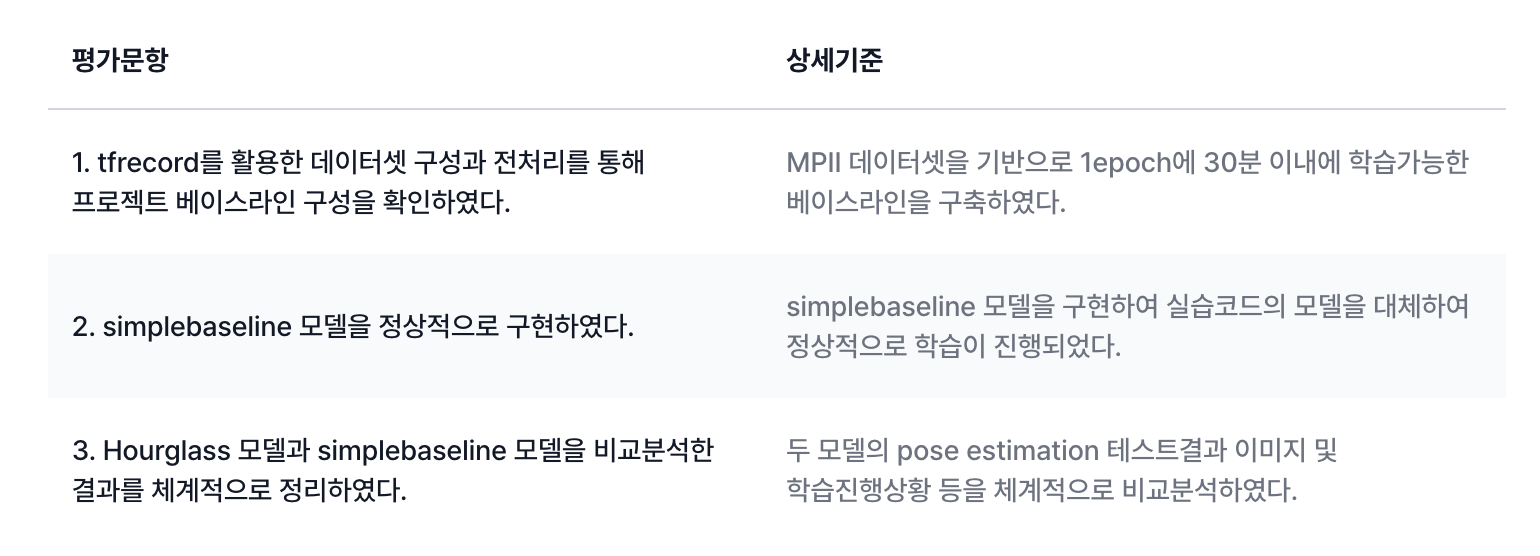

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/workspace/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

# data preprocessing

MPII Human Pose Dataset 사용

### 1. json parsing

json파일에 있는 keypoint정보를 label로 만들기 위해 파싱과정이 필요하다.


In [3]:
#  json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


joints 가 우리가 label 로 사용할 keypoint 의 label 이다.  
이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에  
joints_vis 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타낸다.  
MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있다.   
coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있다.

joints 순서는 아래와 같은 순서로 배치되어 저장

0 - 오른쪽 발목  
1 - 오른쪽 무릎  
2 - 오른쪽 엉덩이  
3 - 왼쪽 엉덩이  
4 - 왼쪽 무릎  
5 - 왼쪽 발목  
6 - 골반  
7 - 가슴(흉부)  
8 - 목  
9 - 머리 위  
10 - 오른쪽 손목  
11 - 오른쪽 팔꿈치  
12 - 오른쪽 어깨  
13 - 왼쪽 어깨  
14 - 왼쪽 팔꿈치  
15 - 왼쪽 손목    

scale과 center는 사람 몸의 크기와 중심점.  
scale은 200을 곱해야 온전한 크기가 된다.  
추후에 전처리 과정에서 200을 곱해서 사용할 예정이다.



In [4]:
# json annotation 파싱

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [5]:
# annotation이 우리가 뽑고자하는 형식 대로 나오는지 확인해보기

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/workspace/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


### TFRecord 파일 만들기

앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들어 보자!

In [6]:
# TFRecord 는 tf.train.Example들의 합으로 이루어지므로 
# 하나의 annotation을 하나의 tf.train.Example로 만들어 주는 함수 작성

def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [7]:
# 하나의 annotation이 tf.train.Example이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수 구현

# 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들기 위해 얼마나 많은 TFRecord를 만들지 결정할 함수를 구현
# 전체 데이터를 몇 개의 그룹으로 나눌지 결정. 
# -> 전체 데이터 l을 n그룹으로 나누고 결과적으로 n개의 TFRecord 파일을 만든다.

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results



In [8]:
#chunkify함수 이해를 위한 출력 확인

test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

ㄴ> 0이 1000개 있는 하나의 리스트가 64개의 리스트로 쪼개어져 분할되었다.  
리스트 하나 당 15개씩 들어있다고 보면 된다.

In [9]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수 구현

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)


**결국 chunk안에는 여러 annotation들이 있고, annotation들은 tf.train.Example로 변환된 후에 문자열로 직렬화되어 TFRecord에 담긴다.**

In [10]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


In [11]:
# 앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어, train 데이터는 64개로, val 데이터는 8개의 파일로 만든다

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2023-12-06 01:36:31,120	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.86gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/workspace/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/workspace/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], 

(build_single_tfrecord pid=145) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0024_of_0064.tfrecords
(build_single_tfrecord pid=145) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=144) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=144) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=143) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=143) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=145) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=145) star

(build_single_tfrecord pid=145) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0052_of_0064.tfrecords
(build_single_tfrecord pid=145) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=144) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0053_of_0064.tfrecords
(build_single_tfrecord pid=144) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=143) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=143) start to build tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=145) finished building tf records for /aiffel/aiffel/workspace/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=145) star

TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요합니다.  
tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단합니다.  
주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다는 점이에요.  
데이터의 형식도 동일하게 맞춰 줘야 합니다.  
라고한다..

In [3]:
# 지금까지 만든 함수들을 객체 형태로 조합.  
# 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많다.  
# 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 한다.

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)


## Modeling

### 1. simplebaseline 모델

In [4]:
# deconv layer 함수화

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)
# 마지막 layer: output
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [5]:
def Simplebaseline(input_shape=(256, 256, 3)):
    # resnet backbone
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
                                                   
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    
    return model

In [6]:
simplebase_model = Simplebaseline()

simplebase_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


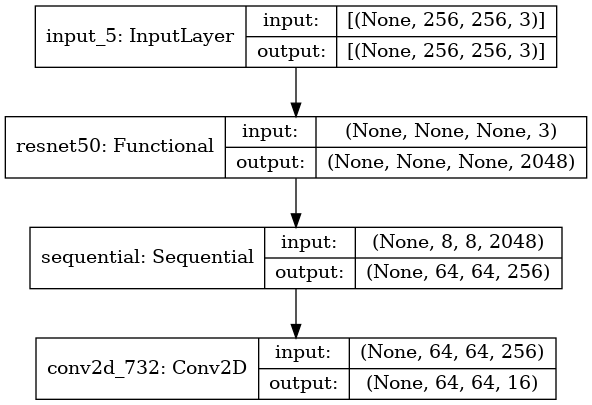

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(simplebase_model, show_shapes=True)

### 2. Hourglass 모델 

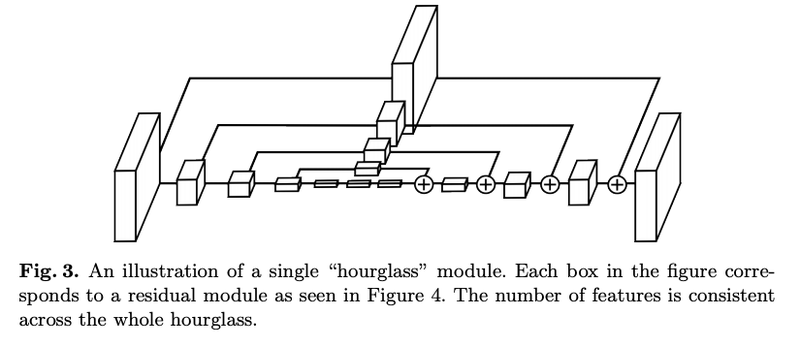

In [4]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


In [5]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


- intermediate output을 위한 linear layer

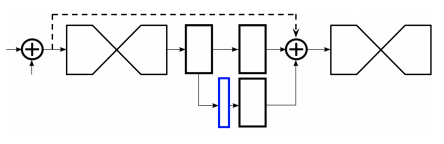

In [6]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산.

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass.

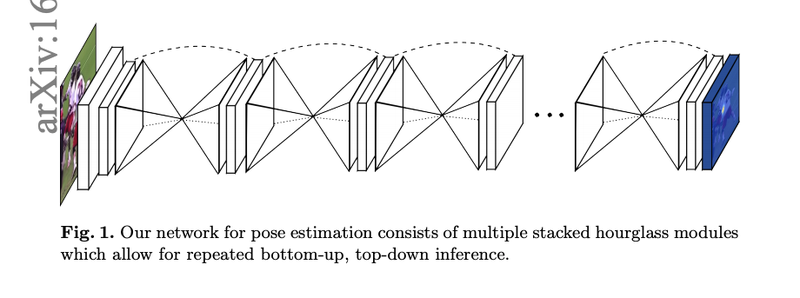

In [7]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')


In [8]:
stacked_model = StackedHourglassNetwork()
stacked_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

__________________________________________________________________________________________________
re_lu_218 (ReLU)                (None, 8, 8, 128)    0           batch_normalization_218[0][0]    
__________________________________________________________________________________________________
batch_normalization_197 (BatchN (None, 16, 16, 128)  512         conv2d_207[0][0]                 
__________________________________________________________________________________________________
re_lu_184 (ReLU)                (None, 32, 32, 256)  0           batch_normalization_184[0][0]    
__________________________________________________________________________________________________
conv2d_229 (Conv2D)             (None, 8, 8, 128)    147584      re_lu_218[0][0]                  
__________________________________________________________________________________________________
re_lu_197 (ReLU)                (None, 16, 16, 128)  0           batch_normalization_197[0][0]    
__________

### 모델 학습

In [7]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        self.train_loss = []
        self.val_loss = []
        self.is_simple = True

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def comput_loss_simplebase(self, labels, outputs):
        loss = 0
        weights = tf.cast(labels > 0, dtype = tf.float32) * 81 + 1
        loss += tf.math.reduce_mean(tf.math.square(labels - outputs) * weights) *( 1./self.global_batch_size)
        
        return loss
    
    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            
            if self.is_simple:
                loss = self.comput_loss_simplebase(labels, outputs)
            else:
                loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        
        if self.is_simple:
                loss = self.comput_loss_simplebase(labels, outputs)
        else:
            loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
        
        
        return self.best_model, self.train_loss, self.val_loss

    def save_model(self, epoch, loss):
        model_name = os.getenv('HOME') + '/aiffel/aiffel_6/GD08/weights' + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


In [9]:
# 데이터셋을 만드는 함수를 작성. 
# TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러오기.

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [9]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        trainer
        return trainer.run(train_dist_dataset, val_dist_dataset)


In [10]:
def simple_base_train(epochs, learning_rate,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join(weight_path)):
        os.makedirs(os.path.join(weight_path))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            )

        print('Start training...')
        trainer
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [7]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007

weight_path = os.getenv('HOME') + '/aiffel/aiffel_6/GD08/weights'

In [15]:
# stackedhourglass 모델 학습

stacked_model, train_loss, val_loss = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 1.99796557 epoch total loss 1.99796557
Trained batch 2 batch loss 1.9968555 epoch total loss 1.99741054
Trained batch 3 batch loss 2.14773 epoch total loss 2.04751706
Trained batch 4 batch loss 2.25133538 epoch total loss 2.09847164
Trained batch 5 batch loss 2.43087697 epoch total loss 2.16495275
Trained batch 6 batch loss 2.17835903 epoch total loss 2.16718698
Trained batch 7 batch loss 2.12924504 epoch total loss 2.16176677
Trained batch 8 batch loss 2.06087303 epoch total loss 2.14915514
Trained batch 9 batch loss 2.2273016 epoch total loss 2.15783811
Trained batch 10 batch loss 2.31923485 epoch total loss 2.17397785
Trained batch 11 batch loss 2.21851778 epoch total loss 2.17802691
Trained batch 12 batch loss 2.25453043 epoch total loss 2.18440223
Trained batch 13 batch loss 2.1676445 epoch total loss 2.1831131
Trained batch 14 batch loss 2.16458273 epoch total loss 2.18178964
Trained batch 15 batch loss 2.0471313 epoch tot

Trained batch 124 batch loss 1.55881834 epoch total loss 1.80196333
Trained batch 125 batch loss 1.59345317 epoch total loss 1.80029523
Trained batch 126 batch loss 1.5956403 epoch total loss 1.79867101
Trained batch 127 batch loss 1.63416815 epoch total loss 1.7973758
Trained batch 128 batch loss 1.64744937 epoch total loss 1.79620445
Trained batch 129 batch loss 1.64447105 epoch total loss 1.79502821
Trained batch 130 batch loss 1.68950486 epoch total loss 1.79421639
Trained batch 131 batch loss 1.77148557 epoch total loss 1.79404294
Trained batch 132 batch loss 1.73088956 epoch total loss 1.79356456
Trained batch 133 batch loss 1.5743469 epoch total loss 1.79191625
Trained batch 134 batch loss 1.62258387 epoch total loss 1.79065263
Trained batch 135 batch loss 1.68457019 epoch total loss 1.78986681
Trained batch 136 batch loss 1.71082115 epoch total loss 1.78928554
Trained batch 137 batch loss 1.61118221 epoch total loss 1.78798544
Trained batch 138 batch loss 1.61769247 epoch total

Trained batch 246 batch loss 1.57333589 epoch total loss 1.72738504
Trained batch 247 batch loss 1.630409 epoch total loss 1.72699237
Trained batch 248 batch loss 1.60299504 epoch total loss 1.7264924
Trained batch 249 batch loss 1.65658605 epoch total loss 1.72621167
Trained batch 250 batch loss 1.54113925 epoch total loss 1.72547126
Trained batch 251 batch loss 1.53872454 epoch total loss 1.72472727
Trained batch 252 batch loss 1.54951549 epoch total loss 1.72403204
Trained batch 253 batch loss 1.58376431 epoch total loss 1.72347772
Trained batch 254 batch loss 1.61256838 epoch total loss 1.72304106
Trained batch 255 batch loss 1.57967317 epoch total loss 1.72247887
Trained batch 256 batch loss 1.63059413 epoch total loss 1.72211993
Trained batch 257 batch loss 1.61580133 epoch total loss 1.72170627
Trained batch 258 batch loss 1.62886357 epoch total loss 1.7213465
Trained batch 259 batch loss 1.63159227 epoch total loss 1.721
Trained batch 260 batch loss 1.56724215 epoch total loss 

Trained batch 367 batch loss 1.42691457 epoch total loss 1.68920732
Trained batch 368 batch loss 1.52110386 epoch total loss 1.68875051
Trained batch 369 batch loss 1.51384544 epoch total loss 1.68827653
Trained batch 370 batch loss 1.51954794 epoch total loss 1.68782055
Trained batch 371 batch loss 1.53503346 epoch total loss 1.68740869
Trained batch 372 batch loss 1.60697985 epoch total loss 1.68719256
Trained batch 373 batch loss 1.53818536 epoch total loss 1.68679309
Trained batch 374 batch loss 1.57681179 epoch total loss 1.686499
Trained batch 375 batch loss 1.6251204 epoch total loss 1.68633533
Trained batch 376 batch loss 1.52521849 epoch total loss 1.68590677
Trained batch 377 batch loss 1.59916747 epoch total loss 1.68567669
Trained batch 378 batch loss 1.52592206 epoch total loss 1.6852541
Trained batch 379 batch loss 1.60663366 epoch total loss 1.68504667
Trained batch 380 batch loss 1.55443716 epoch total loss 1.68470299
Trained batch 381 batch loss 1.55925441 epoch total 

Trained batch 489 batch loss 1.39523089 epoch total loss 1.65743685
Trained batch 490 batch loss 1.45533442 epoch total loss 1.65702438
Trained batch 491 batch loss 1.33577156 epoch total loss 1.65637
Trained batch 492 batch loss 1.41385257 epoch total loss 1.65587723
Trained batch 493 batch loss 1.55007458 epoch total loss 1.65566254
Trained batch 494 batch loss 1.49856198 epoch total loss 1.65534449
Trained batch 495 batch loss 1.45511627 epoch total loss 1.65494
Trained batch 496 batch loss 1.47374773 epoch total loss 1.65457475
Trained batch 497 batch loss 1.57208276 epoch total loss 1.65440869
Trained batch 498 batch loss 1.45749831 epoch total loss 1.6540134
Trained batch 499 batch loss 1.39275169 epoch total loss 1.65348983
Trained batch 500 batch loss 1.46223378 epoch total loss 1.65310729
Trained batch 501 batch loss 1.52737713 epoch total loss 1.65285635
Trained batch 502 batch loss 1.60100508 epoch total loss 1.65275311
Trained batch 503 batch loss 1.5639019 epoch total loss

Trained batch 610 batch loss 1.58381176 epoch total loss 1.63195646
Trained batch 611 batch loss 1.60906196 epoch total loss 1.63191903
Trained batch 612 batch loss 1.63362789 epoch total loss 1.63192177
Trained batch 613 batch loss 1.68516636 epoch total loss 1.63200867
Trained batch 614 batch loss 1.5010289 epoch total loss 1.63179541
Trained batch 615 batch loss 1.54583728 epoch total loss 1.63165557
Trained batch 616 batch loss 1.38483036 epoch total loss 1.63125491
Trained batch 617 batch loss 1.27596498 epoch total loss 1.63067901
Trained batch 618 batch loss 1.47526574 epoch total loss 1.6304276
Trained batch 619 batch loss 1.42778301 epoch total loss 1.63010025
Trained batch 620 batch loss 1.25101519 epoch total loss 1.62948883
Trained batch 621 batch loss 1.22667933 epoch total loss 1.62884021
Trained batch 622 batch loss 1.29945302 epoch total loss 1.62831056
Trained batch 623 batch loss 1.37604403 epoch total loss 1.62790573
Trained batch 624 batch loss 1.42398691 epoch tota

Trained batch 731 batch loss 1.22886539 epoch total loss 1.61120152
Trained batch 732 batch loss 1.22715974 epoch total loss 1.61067688
Trained batch 733 batch loss 1.2307117 epoch total loss 1.61015856
Trained batch 734 batch loss 1.55706716 epoch total loss 1.61008608
Trained batch 735 batch loss 1.65481424 epoch total loss 1.610147
Trained batch 736 batch loss 1.69090748 epoch total loss 1.61025667
Trained batch 737 batch loss 1.64059567 epoch total loss 1.61029792
Trained batch 738 batch loss 1.4860065 epoch total loss 1.61012948
Trained batch 739 batch loss 1.49396944 epoch total loss 1.60997236
Trained batch 740 batch loss 1.41355908 epoch total loss 1.60970688
Trained batch 741 batch loss 1.49352324 epoch total loss 1.60955012
Trained batch 742 batch loss 1.52811551 epoch total loss 1.60944033
Trained batch 743 batch loss 1.395648 epoch total loss 1.60915256
Trained batch 744 batch loss 1.42373455 epoch total loss 1.60890329
Trained batch 745 batch loss 1.46395755 epoch total lo

Trained batch 853 batch loss 1.43835855 epoch total loss 1.59395087
Trained batch 854 batch loss 1.35552955 epoch total loss 1.59367168
Trained batch 855 batch loss 1.22463048 epoch total loss 1.59324
Trained batch 856 batch loss 1.24496305 epoch total loss 1.59283316
Trained batch 857 batch loss 1.39175177 epoch total loss 1.59259856
Trained batch 858 batch loss 1.65903926 epoch total loss 1.59267592
Trained batch 859 batch loss 1.58244824 epoch total loss 1.592664
Trained batch 860 batch loss 1.44284666 epoch total loss 1.59248984
Trained batch 861 batch loss 1.49672115 epoch total loss 1.59237862
Trained batch 862 batch loss 1.44108558 epoch total loss 1.59220302
Trained batch 863 batch loss 1.39263844 epoch total loss 1.59197176
Trained batch 864 batch loss 1.49425244 epoch total loss 1.59185863
Trained batch 865 batch loss 1.41899443 epoch total loss 1.59165871
Trained batch 866 batch loss 1.4085691 epoch total loss 1.59144735
Trained batch 867 batch loss 1.43670416 epoch total lo

Trained batch 975 batch loss 1.45613849 epoch total loss 1.57691896
Trained batch 976 batch loss 1.58391213 epoch total loss 1.57692611
Trained batch 977 batch loss 1.54605687 epoch total loss 1.5768944
Trained batch 978 batch loss 1.36807466 epoch total loss 1.5766809
Trained batch 979 batch loss 1.49884927 epoch total loss 1.57660139
Trained batch 980 batch loss 1.38420165 epoch total loss 1.57640505
Trained batch 981 batch loss 1.56164825 epoch total loss 1.57639
Trained batch 982 batch loss 1.50286984 epoch total loss 1.57631516
Trained batch 983 batch loss 1.40367699 epoch total loss 1.57613957
Trained batch 984 batch loss 1.51848745 epoch total loss 1.57608092
Trained batch 985 batch loss 1.59720993 epoch total loss 1.57610238
Trained batch 986 batch loss 1.59540725 epoch total loss 1.57612193
Trained batch 987 batch loss 1.52451861 epoch total loss 1.57606971
Trained batch 988 batch loss 1.50494087 epoch total loss 1.57599771
Trained batch 989 batch loss 1.4576323 epoch total lo

Trained batch 1095 batch loss 1.37189054 epoch total loss 1.56562364
Trained batch 1096 batch loss 1.35181177 epoch total loss 1.56542861
Trained batch 1097 batch loss 1.40563571 epoch total loss 1.56528294
Trained batch 1098 batch loss 1.60157692 epoch total loss 1.56531596
Trained batch 1099 batch loss 1.4295994 epoch total loss 1.56519246
Trained batch 1100 batch loss 1.40801668 epoch total loss 1.56504953
Trained batch 1101 batch loss 1.50237608 epoch total loss 1.56499255
Trained batch 1102 batch loss 1.39651144 epoch total loss 1.5648396
Trained batch 1103 batch loss 1.52334785 epoch total loss 1.56480193
Trained batch 1104 batch loss 1.50366068 epoch total loss 1.56474662
Trained batch 1105 batch loss 1.56164896 epoch total loss 1.56474376
Trained batch 1106 batch loss 1.53447115 epoch total loss 1.56471634
Trained batch 1107 batch loss 1.54772913 epoch total loss 1.56470096
Trained batch 1108 batch loss 1.42796755 epoch total loss 1.56457758
Trained batch 1109 batch loss 1.5012

Trained batch 1215 batch loss 1.43169546 epoch total loss 1.55569339
Trained batch 1216 batch loss 1.52799475 epoch total loss 1.55567062
Trained batch 1217 batch loss 1.5252651 epoch total loss 1.55564559
Trained batch 1218 batch loss 1.45804036 epoch total loss 1.55556548
Trained batch 1219 batch loss 1.50157452 epoch total loss 1.55552113
Trained batch 1220 batch loss 1.51850319 epoch total loss 1.55549085
Trained batch 1221 batch loss 1.53731084 epoch total loss 1.55547595
Trained batch 1222 batch loss 1.51053452 epoch total loss 1.55543923
Trained batch 1223 batch loss 1.48702967 epoch total loss 1.55538332
Trained batch 1224 batch loss 1.49933362 epoch total loss 1.55533755
Trained batch 1225 batch loss 1.46362603 epoch total loss 1.55526268
Trained batch 1226 batch loss 1.46820736 epoch total loss 1.55519176
Trained batch 1227 batch loss 1.45964587 epoch total loss 1.55511379
Trained batch 1228 batch loss 1.45655966 epoch total loss 1.55503356
Trained batch 1229 batch loss 1.459

Trained batch 1335 batch loss 1.36355364 epoch total loss 1.54491103
Trained batch 1336 batch loss 1.34619713 epoch total loss 1.54476237
Trained batch 1337 batch loss 1.32675409 epoch total loss 1.54459918
Trained batch 1338 batch loss 1.34533668 epoch total loss 1.54445016
Trained batch 1339 batch loss 1.45074666 epoch total loss 1.54438019
Trained batch 1340 batch loss 1.4873147 epoch total loss 1.54433763
Trained batch 1341 batch loss 1.50953853 epoch total loss 1.54431164
Trained batch 1342 batch loss 1.4918313 epoch total loss 1.54427254
Trained batch 1343 batch loss 1.57597709 epoch total loss 1.54429615
Trained batch 1344 batch loss 1.68298602 epoch total loss 1.5443995
Trained batch 1345 batch loss 1.57440913 epoch total loss 1.54442179
Trained batch 1346 batch loss 1.37463713 epoch total loss 1.54429579
Trained batch 1347 batch loss 1.53628564 epoch total loss 1.54428983
Trained batch 1348 batch loss 1.40926445 epoch total loss 1.54418969
Trained batch 1349 batch loss 1.55394

Validated batch 110 batch loss 1.27080512
Validated batch 111 batch loss 1.39826667
Validated batch 112 batch loss 1.41269445
Validated batch 113 batch loss 1.36222792
Validated batch 114 batch loss 1.60004807
Validated batch 115 batch loss 1.36413944
Validated batch 116 batch loss 1.52352023
Validated batch 117 batch loss 1.55572414
Validated batch 118 batch loss 1.43383944
Validated batch 119 batch loss 1.3439343
Validated batch 120 batch loss 1.46308732
Validated batch 121 batch loss 1.38183117
Validated batch 122 batch loss 1.38561451
Validated batch 123 batch loss 1.37366867
Validated batch 124 batch loss 1.32928705
Validated batch 125 batch loss 1.58183062
Validated batch 126 batch loss 1.35398698
Validated batch 127 batch loss 1.35490203
Validated batch 128 batch loss 1.3628149
Validated batch 129 batch loss 1.56385636
Validated batch 130 batch loss 1.4280858
Validated batch 131 batch loss 1.50415778
Validated batch 132 batch loss 1.35243869
Validated batch 133 batch loss 1.5200

Trained batch 74 batch loss 1.51193142 epoch total loss 1.46528292
Trained batch 75 batch loss 1.55931282 epoch total loss 1.46653664
Trained batch 76 batch loss 1.53057361 epoch total loss 1.46737921
Trained batch 77 batch loss 1.5127486 epoch total loss 1.46796846
Trained batch 78 batch loss 1.47667 epoch total loss 1.46807992
Trained batch 79 batch loss 1.40161908 epoch total loss 1.46723866
Trained batch 80 batch loss 1.40945196 epoch total loss 1.46651638
Trained batch 81 batch loss 1.4882859 epoch total loss 1.46678519
Trained batch 82 batch loss 1.54456353 epoch total loss 1.46773374
Trained batch 83 batch loss 1.45651376 epoch total loss 1.46759856
Trained batch 84 batch loss 1.404809 epoch total loss 1.466851
Trained batch 85 batch loss 1.33218932 epoch total loss 1.46526682
Trained batch 86 batch loss 1.37785649 epoch total loss 1.46425033
Trained batch 87 batch loss 1.39700007 epoch total loss 1.46347737
Trained batch 88 batch loss 1.35960317 epoch total loss 1.46229696
Trai

Trained batch 196 batch loss 1.40789771 epoch total loss 1.43557441
Trained batch 197 batch loss 1.39487159 epoch total loss 1.43536782
Trained batch 198 batch loss 1.36761236 epoch total loss 1.43502557
Trained batch 199 batch loss 1.25692058 epoch total loss 1.43413067
Trained batch 200 batch loss 1.20634234 epoch total loss 1.43299162
Trained batch 201 batch loss 1.37149525 epoch total loss 1.43268561
Trained batch 202 batch loss 1.35719371 epoch total loss 1.43231201
Trained batch 203 batch loss 1.38456261 epoch total loss 1.43207669
Trained batch 204 batch loss 1.41782701 epoch total loss 1.43200684
Trained batch 205 batch loss 1.36587429 epoch total loss 1.43168426
Trained batch 206 batch loss 1.39254892 epoch total loss 1.43149424
Trained batch 207 batch loss 1.49163151 epoch total loss 1.43178487
Trained batch 208 batch loss 1.53958797 epoch total loss 1.43230307
Trained batch 209 batch loss 1.34168696 epoch total loss 1.43186939
Trained batch 210 batch loss 1.42398727 epoch to

Trained batch 317 batch loss 1.36728239 epoch total loss 1.42018831
Trained batch 318 batch loss 1.39827275 epoch total loss 1.4201194
Trained batch 319 batch loss 1.39625645 epoch total loss 1.42004466
Trained batch 320 batch loss 1.41764 epoch total loss 1.42003703
Trained batch 321 batch loss 1.24829304 epoch total loss 1.41950202
Trained batch 322 batch loss 1.4009738 epoch total loss 1.41944444
Trained batch 323 batch loss 1.40262628 epoch total loss 1.41939235
Trained batch 324 batch loss 1.46809757 epoch total loss 1.41954279
Trained batch 325 batch loss 1.38193583 epoch total loss 1.41942704
Trained batch 326 batch loss 1.37164891 epoch total loss 1.41928041
Trained batch 327 batch loss 1.37187576 epoch total loss 1.41913545
Trained batch 328 batch loss 1.34653521 epoch total loss 1.4189142
Trained batch 329 batch loss 1.3108772 epoch total loss 1.41858578
Trained batch 330 batch loss 1.32906961 epoch total loss 1.41831458
Trained batch 331 batch loss 1.32683313 epoch total los

Trained batch 438 batch loss 1.56861806 epoch total loss 1.41042709
Trained batch 439 batch loss 1.52724266 epoch total loss 1.41069317
Trained batch 440 batch loss 1.63043165 epoch total loss 1.41119266
Trained batch 441 batch loss 1.56683302 epoch total loss 1.41154552
Trained batch 442 batch loss 1.19818723 epoch total loss 1.41106284
Trained batch 443 batch loss 1.39428329 epoch total loss 1.41102493
Trained batch 444 batch loss 1.35845423 epoch total loss 1.41090655
Trained batch 445 batch loss 1.3104161 epoch total loss 1.41068077
Trained batch 446 batch loss 1.35252011 epoch total loss 1.41055036
Trained batch 447 batch loss 1.3176837 epoch total loss 1.41034257
Trained batch 448 batch loss 1.37023902 epoch total loss 1.41025317
Trained batch 449 batch loss 1.33817589 epoch total loss 1.41009259
Trained batch 450 batch loss 1.30849326 epoch total loss 1.40986681
Trained batch 451 batch loss 1.24799371 epoch total loss 1.40950787
Trained batch 452 batch loss 1.36446071 epoch tota

Trained batch 559 batch loss 1.30962205 epoch total loss 1.40377975
Trained batch 560 batch loss 1.35742974 epoch total loss 1.40369701
Trained batch 561 batch loss 1.35449052 epoch total loss 1.40360928
Trained batch 562 batch loss 1.32059145 epoch total loss 1.40346158
Trained batch 563 batch loss 1.36576819 epoch total loss 1.4033947
Trained batch 564 batch loss 1.3076117 epoch total loss 1.40322483
Trained batch 565 batch loss 1.40459335 epoch total loss 1.40322733
Trained batch 566 batch loss 1.38150764 epoch total loss 1.40318894
Trained batch 567 batch loss 1.49864864 epoch total loss 1.40335739
Trained batch 568 batch loss 1.42633355 epoch total loss 1.4033978
Trained batch 569 batch loss 1.25130582 epoch total loss 1.40313041
Trained batch 570 batch loss 1.26341915 epoch total loss 1.40288532
Trained batch 571 batch loss 1.30658495 epoch total loss 1.40271664
Trained batch 572 batch loss 1.43592215 epoch total loss 1.40277469
Trained batch 573 batch loss 1.448084 epoch total l

Trained batch 681 batch loss 1.30932105 epoch total loss 1.39606202
Trained batch 682 batch loss 1.32355237 epoch total loss 1.39595568
Trained batch 683 batch loss 1.31771016 epoch total loss 1.395841
Trained batch 684 batch loss 1.34612286 epoch total loss 1.3957684
Trained batch 685 batch loss 1.41909981 epoch total loss 1.3958025
Trained batch 686 batch loss 1.59240949 epoch total loss 1.39608908
Trained batch 687 batch loss 1.55198956 epoch total loss 1.39631605
Trained batch 688 batch loss 1.44011235 epoch total loss 1.39637971
Trained batch 689 batch loss 1.65380287 epoch total loss 1.39675331
Trained batch 690 batch loss 1.27580762 epoch total loss 1.39657807
Trained batch 691 batch loss 1.19238877 epoch total loss 1.39628255
Trained batch 692 batch loss 1.16938686 epoch total loss 1.39595461
Trained batch 693 batch loss 1.07724333 epoch total loss 1.39549482
Trained batch 694 batch loss 1.22640896 epoch total loss 1.39525115
Trained batch 695 batch loss 1.33558917 epoch total 

Trained batch 803 batch loss 1.13962781 epoch total loss 1.38764715
Trained batch 804 batch loss 1.22287083 epoch total loss 1.38744223
Trained batch 805 batch loss 1.30174804 epoch total loss 1.38733578
Trained batch 806 batch loss 1.42809486 epoch total loss 1.38738632
Trained batch 807 batch loss 1.43032408 epoch total loss 1.38743949
Trained batch 808 batch loss 1.43323636 epoch total loss 1.38749623
Trained batch 809 batch loss 1.53630853 epoch total loss 1.38768
Trained batch 810 batch loss 1.40474 epoch total loss 1.38770115
Trained batch 811 batch loss 1.38420379 epoch total loss 1.38769686
Trained batch 812 batch loss 1.41604447 epoch total loss 1.38773167
Trained batch 813 batch loss 1.45102572 epoch total loss 1.38780963
Trained batch 814 batch loss 1.46534717 epoch total loss 1.38790476
Trained batch 815 batch loss 1.28226483 epoch total loss 1.38777518
Trained batch 816 batch loss 1.30287027 epoch total loss 1.38767111
Trained batch 817 batch loss 1.20095754 epoch total lo

Trained batch 925 batch loss 1.45751858 epoch total loss 1.38622165
Trained batch 926 batch loss 1.3771317 epoch total loss 1.38621175
Trained batch 927 batch loss 1.50281286 epoch total loss 1.38633752
Trained batch 928 batch loss 1.42821 epoch total loss 1.3863827
Trained batch 929 batch loss 1.50972235 epoch total loss 1.3865155
Trained batch 930 batch loss 1.4149878 epoch total loss 1.38654613
Trained batch 931 batch loss 1.51078022 epoch total loss 1.38667953
Trained batch 932 batch loss 1.45940447 epoch total loss 1.38675749
Trained batch 933 batch loss 1.43677568 epoch total loss 1.38681114
Trained batch 934 batch loss 1.48037493 epoch total loss 1.38691127
Trained batch 935 batch loss 1.51847863 epoch total loss 1.38705194
Trained batch 936 batch loss 1.46523941 epoch total loss 1.38713539
Trained batch 937 batch loss 1.3555212 epoch total loss 1.38710165
Trained batch 938 batch loss 1.35881078 epoch total loss 1.38707137
Trained batch 939 batch loss 1.35731971 epoch total loss

Trained batch 1046 batch loss 1.20128345 epoch total loss 1.38006473
Trained batch 1047 batch loss 1.32861567 epoch total loss 1.38001561
Trained batch 1048 batch loss 1.44364727 epoch total loss 1.38007629
Trained batch 1049 batch loss 1.38586867 epoch total loss 1.38008177
Trained batch 1050 batch loss 1.29065108 epoch total loss 1.37999666
Trained batch 1051 batch loss 1.32986176 epoch total loss 1.37994885
Trained batch 1052 batch loss 1.37556648 epoch total loss 1.3799448
Trained batch 1053 batch loss 1.24870956 epoch total loss 1.37982011
Trained batch 1054 batch loss 1.21246254 epoch total loss 1.3796612
Trained batch 1055 batch loss 1.28518391 epoch total loss 1.37957168
Trained batch 1056 batch loss 1.42732871 epoch total loss 1.37961698
Trained batch 1057 batch loss 1.39018178 epoch total loss 1.37962687
Trained batch 1058 batch loss 1.3427428 epoch total loss 1.37959206
Trained batch 1059 batch loss 1.29880095 epoch total loss 1.37951577
Trained batch 1060 batch loss 1.25367

Trained batch 1166 batch loss 1.23794961 epoch total loss 1.37483525
Trained batch 1167 batch loss 1.31710267 epoch total loss 1.37478578
Trained batch 1168 batch loss 1.35986781 epoch total loss 1.37477303
Trained batch 1169 batch loss 1.39499164 epoch total loss 1.37479031
Trained batch 1170 batch loss 1.39915609 epoch total loss 1.37481117
Trained batch 1171 batch loss 1.39357948 epoch total loss 1.37482715
Trained batch 1172 batch loss 1.41246748 epoch total loss 1.37485933
Trained batch 1173 batch loss 1.38398337 epoch total loss 1.37486708
Trained batch 1174 batch loss 1.37616718 epoch total loss 1.37486827
Trained batch 1175 batch loss 1.39965546 epoch total loss 1.37488937
Trained batch 1176 batch loss 1.33947647 epoch total loss 1.37485921
Trained batch 1177 batch loss 1.41884124 epoch total loss 1.37489665
Trained batch 1178 batch loss 1.41383493 epoch total loss 1.37492967
Trained batch 1179 batch loss 1.37299049 epoch total loss 1.374928
Trained batch 1180 batch loss 1.3628

Trained batch 1286 batch loss 1.22691429 epoch total loss 1.37072325
Trained batch 1287 batch loss 1.24741066 epoch total loss 1.37062752
Trained batch 1288 batch loss 1.20621705 epoch total loss 1.37049985
Trained batch 1289 batch loss 1.26003277 epoch total loss 1.37041402
Trained batch 1290 batch loss 1.31775105 epoch total loss 1.37037325
Trained batch 1291 batch loss 1.26991045 epoch total loss 1.37029541
Trained batch 1292 batch loss 1.24826312 epoch total loss 1.37020099
Trained batch 1293 batch loss 1.20361495 epoch total loss 1.37007213
Trained batch 1294 batch loss 1.37549353 epoch total loss 1.3700763
Trained batch 1295 batch loss 1.35485947 epoch total loss 1.37006462
Trained batch 1296 batch loss 1.37593985 epoch total loss 1.37006915
Trained batch 1297 batch loss 1.25294042 epoch total loss 1.36997879
Trained batch 1298 batch loss 1.2410897 epoch total loss 1.36987948
Trained batch 1299 batch loss 1.13772631 epoch total loss 1.36970079
Trained batch 1300 batch loss 1.0359

Validated batch 28 batch loss 1.41159916
Validated batch 29 batch loss 1.45494592
Validated batch 30 batch loss 1.22693467
Validated batch 31 batch loss 1.34271908
Validated batch 32 batch loss 1.29954791
Validated batch 33 batch loss 1.39149833
Validated batch 34 batch loss 1.3474679
Validated batch 35 batch loss 1.18472862
Validated batch 36 batch loss 1.1942656
Validated batch 37 batch loss 1.30284071
Validated batch 38 batch loss 1.30996394
Validated batch 39 batch loss 1.26507449
Validated batch 40 batch loss 1.3255806
Validated batch 41 batch loss 1.26002562
Validated batch 42 batch loss 1.34101152
Validated batch 43 batch loss 1.36475921
Validated batch 44 batch loss 1.38362634
Validated batch 45 batch loss 1.35827398
Validated batch 46 batch loss 1.22136331
Validated batch 47 batch loss 1.27694106
Validated batch 48 batch loss 1.31069577
Validated batch 49 batch loss 1.28280759
Validated batch 50 batch loss 1.21008372
Validated batch 51 batch loss 1.23321426
Validated batch 52 

Trained batch 24 batch loss 1.399701 epoch total loss 1.37501299
Trained batch 25 batch loss 1.36477923 epoch total loss 1.37460375
Trained batch 26 batch loss 1.36968946 epoch total loss 1.37441468
Trained batch 27 batch loss 1.33924258 epoch total loss 1.37311196
Trained batch 28 batch loss 1.37143934 epoch total loss 1.37305236
Trained batch 29 batch loss 1.33161342 epoch total loss 1.37162328
Trained batch 30 batch loss 1.3462702 epoch total loss 1.37077832
Trained batch 31 batch loss 1.46532631 epoch total loss 1.37382829
Trained batch 32 batch loss 1.29142475 epoch total loss 1.37125313
Trained batch 33 batch loss 1.25482917 epoch total loss 1.36772513
Trained batch 34 batch loss 1.42111278 epoch total loss 1.36929536
Trained batch 35 batch loss 1.36474729 epoch total loss 1.36916542
Trained batch 36 batch loss 1.38870394 epoch total loss 1.36970806
Trained batch 37 batch loss 1.33379316 epoch total loss 1.36873746
Trained batch 38 batch loss 1.37114823 epoch total loss 1.3688007

Trained batch 146 batch loss 1.29698515 epoch total loss 1.32089508
Trained batch 147 batch loss 1.44608557 epoch total loss 1.32174671
Trained batch 148 batch loss 1.36085892 epoch total loss 1.32201099
Trained batch 149 batch loss 1.30937994 epoch total loss 1.32192624
Trained batch 150 batch loss 1.55769253 epoch total loss 1.32349801
Trained batch 151 batch loss 1.48897243 epoch total loss 1.3245939
Trained batch 152 batch loss 1.39072 epoch total loss 1.3250289
Trained batch 153 batch loss 1.35917664 epoch total loss 1.32525206
Trained batch 154 batch loss 1.37306035 epoch total loss 1.32556248
Trained batch 155 batch loss 1.31969905 epoch total loss 1.32552469
Trained batch 156 batch loss 1.30405188 epoch total loss 1.325387
Trained batch 157 batch loss 1.32292414 epoch total loss 1.32537127
Trained batch 158 batch loss 1.32039165 epoch total loss 1.32533979
Trained batch 159 batch loss 1.25166988 epoch total loss 1.32487643
Trained batch 160 batch loss 1.38145483 epoch total los

Trained batch 268 batch loss 1.22452676 epoch total loss 1.31337106
Trained batch 269 batch loss 1.13289368 epoch total loss 1.31270027
Trained batch 270 batch loss 1.24671054 epoch total loss 1.31245577
Trained batch 271 batch loss 1.31834066 epoch total loss 1.31247747
Trained batch 272 batch loss 1.30189741 epoch total loss 1.31243861
Trained batch 273 batch loss 1.35442376 epoch total loss 1.31259251
Trained batch 274 batch loss 1.36042476 epoch total loss 1.31276703
Trained batch 275 batch loss 1.32315683 epoch total loss 1.3128047
Trained batch 276 batch loss 1.40011394 epoch total loss 1.31312108
Trained batch 277 batch loss 1.36787462 epoch total loss 1.31331885
Trained batch 278 batch loss 1.51089752 epoch total loss 1.31402946
Trained batch 279 batch loss 1.37093937 epoch total loss 1.31423354
Trained batch 280 batch loss 1.42871523 epoch total loss 1.31464231
Trained batch 281 batch loss 1.36097527 epoch total loss 1.31480718
Trained batch 282 batch loss 1.33146167 epoch tot

Trained batch 389 batch loss 1.28360033 epoch total loss 1.30927706
Trained batch 390 batch loss 1.29063928 epoch total loss 1.30922925
Trained batch 391 batch loss 1.16999805 epoch total loss 1.30887318
Trained batch 392 batch loss 1.25908589 epoch total loss 1.30874622
Trained batch 393 batch loss 1.26424837 epoch total loss 1.30863285
Trained batch 394 batch loss 1.3574847 epoch total loss 1.30875683
Trained batch 395 batch loss 1.25528598 epoch total loss 1.30862153
Trained batch 396 batch loss 1.33953643 epoch total loss 1.30869961
Trained batch 397 batch loss 1.30477 epoch total loss 1.30868971
Trained batch 398 batch loss 1.1686995 epoch total loss 1.30833793
Trained batch 399 batch loss 1.29139161 epoch total loss 1.30829549
Trained batch 400 batch loss 1.22452605 epoch total loss 1.30808604
Trained batch 401 batch loss 1.25047755 epoch total loss 1.30794251
Trained batch 402 batch loss 1.22360802 epoch total loss 1.3077327
Trained batch 403 batch loss 1.18173027 epoch total lo

Trained batch 511 batch loss 1.11835802 epoch total loss 1.29733491
Trained batch 512 batch loss 1.19270194 epoch total loss 1.29713047
Trained batch 513 batch loss 1.21500564 epoch total loss 1.29697037
Trained batch 514 batch loss 1.27227461 epoch total loss 1.29692233
Trained batch 515 batch loss 1.39726222 epoch total loss 1.29711723
Trained batch 516 batch loss 1.58348846 epoch total loss 1.29767227
Trained batch 517 batch loss 1.31237197 epoch total loss 1.29770064
Trained batch 518 batch loss 1.32463825 epoch total loss 1.29775274
Trained batch 519 batch loss 1.28709888 epoch total loss 1.29773223
Trained batch 520 batch loss 1.18178642 epoch total loss 1.29750919
Trained batch 521 batch loss 1.2956053 epoch total loss 1.2975055
Trained batch 522 batch loss 1.30757046 epoch total loss 1.29752481
Trained batch 523 batch loss 1.30223572 epoch total loss 1.29753375
Trained batch 524 batch loss 1.29172397 epoch total loss 1.29752278
Trained batch 525 batch loss 1.445364 epoch total 

Trained batch 633 batch loss 1.05830991 epoch total loss 1.2926482
Trained batch 634 batch loss 1.11695313 epoch total loss 1.29237103
Trained batch 635 batch loss 1.19153976 epoch total loss 1.29221225
Trained batch 636 batch loss 1.233953 epoch total loss 1.29212058
Trained batch 637 batch loss 1.30908346 epoch total loss 1.29214716
Trained batch 638 batch loss 1.16785181 epoch total loss 1.29195237
Trained batch 639 batch loss 1.30147099 epoch total loss 1.29196727
Trained batch 640 batch loss 1.26060987 epoch total loss 1.29191828
Trained batch 641 batch loss 1.39846826 epoch total loss 1.29208457
Trained batch 642 batch loss 1.30525935 epoch total loss 1.29210508
Trained batch 643 batch loss 1.15374017 epoch total loss 1.29188991
Trained batch 644 batch loss 1.20882988 epoch total loss 1.2917608
Trained batch 645 batch loss 1.27601218 epoch total loss 1.29173636
Trained batch 646 batch loss 1.39920139 epoch total loss 1.29190278
Trained batch 647 batch loss 1.50046277 epoch total 

Trained batch 754 batch loss 1.24825656 epoch total loss 1.28692663
Trained batch 755 batch loss 1.3576324 epoch total loss 1.28702033
Trained batch 756 batch loss 1.28622699 epoch total loss 1.28701925
Trained batch 757 batch loss 1.34061456 epoch total loss 1.28709006
Trained batch 758 batch loss 1.35201931 epoch total loss 1.28717577
Trained batch 759 batch loss 1.33163357 epoch total loss 1.28723431
Trained batch 760 batch loss 1.26069248 epoch total loss 1.28719938
Trained batch 761 batch loss 1.28551948 epoch total loss 1.28719711
Trained batch 762 batch loss 1.1775167 epoch total loss 1.28705311
Trained batch 763 batch loss 1.19961584 epoch total loss 1.28693855
Trained batch 764 batch loss 1.34497 epoch total loss 1.2870146
Trained batch 765 batch loss 1.39357424 epoch total loss 1.28715384
Trained batch 766 batch loss 1.3422116 epoch total loss 1.28722572
Trained batch 767 batch loss 1.2248745 epoch total loss 1.28714442
Trained batch 768 batch loss 1.23212028 epoch total loss

Trained batch 876 batch loss 1.27038991 epoch total loss 1.28775191
Trained batch 877 batch loss 1.35213518 epoch total loss 1.28782535
Trained batch 878 batch loss 1.21645939 epoch total loss 1.28774405
Trained batch 879 batch loss 1.20062482 epoch total loss 1.28764498
Trained batch 880 batch loss 1.31048548 epoch total loss 1.28767085
Trained batch 881 batch loss 1.46632814 epoch total loss 1.28787363
Trained batch 882 batch loss 1.42420363 epoch total loss 1.28802824
Trained batch 883 batch loss 1.49200249 epoch total loss 1.28825915
Trained batch 884 batch loss 1.32040834 epoch total loss 1.28829551
Trained batch 885 batch loss 1.2792567 epoch total loss 1.28828537
Trained batch 886 batch loss 1.26605105 epoch total loss 1.28826022
Trained batch 887 batch loss 1.46770263 epoch total loss 1.28846252
Trained batch 888 batch loss 1.46890092 epoch total loss 1.28866565
Trained batch 889 batch loss 1.33044207 epoch total loss 1.28871262
Trained batch 890 batch loss 1.30624318 epoch tot

Trained batch 997 batch loss 1.11426926 epoch total loss 1.28693283
Trained batch 998 batch loss 1.23377824 epoch total loss 1.28687954
Trained batch 999 batch loss 1.16604531 epoch total loss 1.28675854
Trained batch 1000 batch loss 1.36303401 epoch total loss 1.28683484
Trained batch 1001 batch loss 1.24612665 epoch total loss 1.28679419
Trained batch 1002 batch loss 1.39552402 epoch total loss 1.28690267
Trained batch 1003 batch loss 1.45130992 epoch total loss 1.28706658
Trained batch 1004 batch loss 1.37937987 epoch total loss 1.28715849
Trained batch 1005 batch loss 1.30237901 epoch total loss 1.28717363
Trained batch 1006 batch loss 1.35628664 epoch total loss 1.28724241
Trained batch 1007 batch loss 1.2450397 epoch total loss 1.28720045
Trained batch 1008 batch loss 1.23726153 epoch total loss 1.28715086
Trained batch 1009 batch loss 1.32688046 epoch total loss 1.28719032
Trained batch 1010 batch loss 1.45137179 epoch total loss 1.28735292
Trained batch 1011 batch loss 1.349990

Trained batch 1117 batch loss 1.07686615 epoch total loss 1.28441572
Trained batch 1118 batch loss 1.33116865 epoch total loss 1.28445756
Trained batch 1119 batch loss 1.33654511 epoch total loss 1.28450418
Trained batch 1120 batch loss 1.36235976 epoch total loss 1.28457355
Trained batch 1121 batch loss 1.24945211 epoch total loss 1.28454232
Trained batch 1122 batch loss 1.18064809 epoch total loss 1.2844497
Trained batch 1123 batch loss 1.16866934 epoch total loss 1.2843467
Trained batch 1124 batch loss 1.23634017 epoch total loss 1.2843039
Trained batch 1125 batch loss 1.21098328 epoch total loss 1.2842387
Trained batch 1126 batch loss 1.19935083 epoch total loss 1.28416336
Trained batch 1127 batch loss 1.2891531 epoch total loss 1.28416777
Trained batch 1128 batch loss 1.1561873 epoch total loss 1.28405428
Trained batch 1129 batch loss 1.01076138 epoch total loss 1.28381217
Trained batch 1130 batch loss 1.02134216 epoch total loss 1.28358
Trained batch 1131 batch loss 1.17766941 ep

Trained batch 1237 batch loss 1.28809011 epoch total loss 1.2817018
Trained batch 1238 batch loss 1.23759627 epoch total loss 1.28166616
Trained batch 1239 batch loss 1.21325517 epoch total loss 1.28161085
Trained batch 1240 batch loss 1.11859298 epoch total loss 1.28147948
Trained batch 1241 batch loss 1.09117365 epoch total loss 1.28132617
Trained batch 1242 batch loss 1.17395234 epoch total loss 1.28123963
Trained batch 1243 batch loss 1.2040205 epoch total loss 1.28117752
Trained batch 1244 batch loss 1.29183722 epoch total loss 1.2811861
Trained batch 1245 batch loss 1.44141591 epoch total loss 1.28131485
Trained batch 1246 batch loss 1.55670714 epoch total loss 1.28153586
Trained batch 1247 batch loss 1.38188434 epoch total loss 1.28161633
Trained batch 1248 batch loss 1.36176133 epoch total loss 1.28168058
Trained batch 1249 batch loss 1.2741859 epoch total loss 1.2816745
Trained batch 1250 batch loss 1.13901103 epoch total loss 1.28156042
Trained batch 1251 batch loss 1.1772494

Trained batch 1357 batch loss 1.15501857 epoch total loss 1.28054225
Trained batch 1358 batch loss 0.968400478 epoch total loss 1.28031242
Trained batch 1359 batch loss 0.982851684 epoch total loss 1.28009355
Trained batch 1360 batch loss 0.95232749 epoch total loss 1.27985251
Trained batch 1361 batch loss 1.02721989 epoch total loss 1.2796669
Trained batch 1362 batch loss 1.20149255 epoch total loss 1.27960944
Trained batch 1363 batch loss 1.28654313 epoch total loss 1.27961457
Trained batch 1364 batch loss 1.30347276 epoch total loss 1.27963197
Trained batch 1365 batch loss 1.21436822 epoch total loss 1.27958417
Trained batch 1366 batch loss 1.21744657 epoch total loss 1.27953875
Trained batch 1367 batch loss 1.2846657 epoch total loss 1.27954245
Trained batch 1368 batch loss 1.28608894 epoch total loss 1.27954721
Trained batch 1369 batch loss 1.36304057 epoch total loss 1.27960825
Trained batch 1370 batch loss 1.22445393 epoch total loss 1.27956796
Trained batch 1371 batch loss 1.24

Validated batch 146 batch loss 1.1387105
Validated batch 147 batch loss 1.21755552
Validated batch 148 batch loss 1.27024138
Validated batch 149 batch loss 1.12471211
Validated batch 150 batch loss 1.27271938
Validated batch 151 batch loss 1.12384307
Validated batch 152 batch loss 1.23950064
Validated batch 153 batch loss 1.3284061
Validated batch 154 batch loss 1.36037266
Validated batch 155 batch loss 1.18871582
Validated batch 156 batch loss 1.36851621
Validated batch 157 batch loss 1.09327483
Validated batch 158 batch loss 1.12920892
Validated batch 159 batch loss 1.23580134
Validated batch 160 batch loss 1.20497572
Validated batch 161 batch loss 1.35836565
Validated batch 162 batch loss 1.27688098
Validated batch 163 batch loss 1.11534131
Validated batch 164 batch loss 1.20086241
Validated batch 165 batch loss 1.18057275
Validated batch 166 batch loss 1.2047224
Validated batch 167 batch loss 1.25973189
Validated batch 168 batch loss 1.25287664
Validated batch 169 batch loss 1.2912

Trained batch 97 batch loss 1.19648039 epoch total loss 1.23007131
Trained batch 98 batch loss 1.09422696 epoch total loss 1.22868514
Trained batch 99 batch loss 1.16317511 epoch total loss 1.22802353
Trained batch 100 batch loss 1.18140912 epoch total loss 1.22755742
Trained batch 101 batch loss 1.20599198 epoch total loss 1.22734392
Trained batch 102 batch loss 1.20955324 epoch total loss 1.22716951
Trained batch 103 batch loss 1.28312647 epoch total loss 1.22771275
Trained batch 104 batch loss 1.25155175 epoch total loss 1.22794199
Trained batch 105 batch loss 1.18131292 epoch total loss 1.22749794
Trained batch 106 batch loss 1.15611756 epoch total loss 1.22682452
Trained batch 107 batch loss 1.17764735 epoch total loss 1.22636485
Trained batch 108 batch loss 1.20646513 epoch total loss 1.22618055
Trained batch 109 batch loss 1.23115337 epoch total loss 1.22622621
Trained batch 110 batch loss 1.29253399 epoch total loss 1.22682917
Trained batch 111 batch loss 1.34221101 epoch total

Trained batch 218 batch loss 1.16074681 epoch total loss 1.2326045
Trained batch 219 batch loss 1.10448813 epoch total loss 1.23201954
Trained batch 220 batch loss 1.19604814 epoch total loss 1.23185611
Trained batch 221 batch loss 1.14987946 epoch total loss 1.23148513
Trained batch 222 batch loss 1.18218815 epoch total loss 1.23126304
Trained batch 223 batch loss 1.07662845 epoch total loss 1.2305696
Trained batch 224 batch loss 1.11535168 epoch total loss 1.23005521
Trained batch 225 batch loss 1.09175241 epoch total loss 1.22944069
Trained batch 226 batch loss 1.13341188 epoch total loss 1.22901583
Trained batch 227 batch loss 1.17509592 epoch total loss 1.22877836
Trained batch 228 batch loss 1.18001652 epoch total loss 1.2285645
Trained batch 229 batch loss 1.04415774 epoch total loss 1.22775924
Trained batch 230 batch loss 1.25956941 epoch total loss 1.22789752
Trained batch 231 batch loss 1.49930978 epoch total loss 1.22907245
Trained batch 232 batch loss 1.30683625 epoch total

Trained batch 340 batch loss 1.27083337 epoch total loss 1.22975183
Trained batch 341 batch loss 1.33463883 epoch total loss 1.23005927
Trained batch 342 batch loss 1.25575709 epoch total loss 1.23013449
Trained batch 343 batch loss 1.22988832 epoch total loss 1.23013377
Trained batch 344 batch loss 1.21786392 epoch total loss 1.23009813
Trained batch 345 batch loss 1.20070934 epoch total loss 1.23001289
Trained batch 346 batch loss 1.13824296 epoch total loss 1.22974765
Trained batch 347 batch loss 1.16261578 epoch total loss 1.2295543
Trained batch 348 batch loss 1.22322941 epoch total loss 1.22953618
Trained batch 349 batch loss 1.07988656 epoch total loss 1.22910738
Trained batch 350 batch loss 1.32060337 epoch total loss 1.22936881
Trained batch 351 batch loss 1.300529 epoch total loss 1.22957158
Trained batch 352 batch loss 1.3159101 epoch total loss 1.22981691
Trained batch 353 batch loss 1.21122384 epoch total loss 1.22976422
Trained batch 354 batch loss 1.28747439 epoch total 

Trained batch 461 batch loss 1.37604022 epoch total loss 1.2325598
Trained batch 462 batch loss 1.21104574 epoch total loss 1.23251331
Trained batch 463 batch loss 1.22860217 epoch total loss 1.23250484
Trained batch 464 batch loss 1.44171882 epoch total loss 1.23295569
Trained batch 465 batch loss 1.41691017 epoch total loss 1.23335135
Trained batch 466 batch loss 1.23388815 epoch total loss 1.23335242
Trained batch 467 batch loss 1.30626643 epoch total loss 1.23350859
Trained batch 468 batch loss 1.24854016 epoch total loss 1.23354077
Trained batch 469 batch loss 1.30364788 epoch total loss 1.23369026
Trained batch 470 batch loss 1.18829775 epoch total loss 1.23359358
Trained batch 471 batch loss 1.29936886 epoch total loss 1.2337333
Trained batch 472 batch loss 1.26791334 epoch total loss 1.23380566
Trained batch 473 batch loss 1.23539364 epoch total loss 1.23380899
Trained batch 474 batch loss 1.26392913 epoch total loss 1.23387253
Trained batch 475 batch loss 1.35375381 epoch tota

Trained batch 583 batch loss 1.3011 epoch total loss 1.23413754
Trained batch 584 batch loss 1.32574391 epoch total loss 1.23429441
Trained batch 585 batch loss 1.197891 epoch total loss 1.23423219
Trained batch 586 batch loss 1.23447204 epoch total loss 1.23423266
Trained batch 587 batch loss 1.21475744 epoch total loss 1.23419952
Trained batch 588 batch loss 1.29698062 epoch total loss 1.23430634
Trained batch 589 batch loss 1.29241478 epoch total loss 1.23440492
Trained batch 590 batch loss 1.29285061 epoch total loss 1.23450398
Trained batch 591 batch loss 1.06303191 epoch total loss 1.23421395
Trained batch 592 batch loss 0.962901831 epoch total loss 1.23375559
Trained batch 593 batch loss 1.21289468 epoch total loss 1.23372042
Trained batch 594 batch loss 1.28038168 epoch total loss 1.23379898
Trained batch 595 batch loss 1.31853342 epoch total loss 1.23394144
Trained batch 596 batch loss 1.28437054 epoch total loss 1.23402596
Trained batch 597 batch loss 1.37270975 epoch total l

Trained batch 704 batch loss 1.15799654 epoch total loss 1.23275197
Trained batch 705 batch loss 1.16967654 epoch total loss 1.23266256
Trained batch 706 batch loss 1.28661191 epoch total loss 1.23273897
Trained batch 707 batch loss 1.29219985 epoch total loss 1.23282301
Trained batch 708 batch loss 1.19978547 epoch total loss 1.2327764
Trained batch 709 batch loss 1.16432047 epoch total loss 1.23267984
Trained batch 710 batch loss 1.13254297 epoch total loss 1.23253882
Trained batch 711 batch loss 1.09286058 epoch total loss 1.23234224
Trained batch 712 batch loss 1.19611442 epoch total loss 1.23229146
Trained batch 713 batch loss 1.12979722 epoch total loss 1.23214769
Trained batch 714 batch loss 1.1034615 epoch total loss 1.23196745
Trained batch 715 batch loss 1.15591967 epoch total loss 1.23186111
Trained batch 716 batch loss 1.23193777 epoch total loss 1.23186123
Trained batch 717 batch loss 1.30194116 epoch total loss 1.23195899
Trained batch 718 batch loss 1.22288799 epoch tota

Trained batch 825 batch loss 1.22049689 epoch total loss 1.22926533
Trained batch 826 batch loss 1.1518085 epoch total loss 1.22917151
Trained batch 827 batch loss 1.07861423 epoch total loss 1.22898948
Trained batch 828 batch loss 1.16048479 epoch total loss 1.22890663
Trained batch 829 batch loss 1.36460471 epoch total loss 1.22907043
Trained batch 830 batch loss 1.30629802 epoch total loss 1.22916341
Trained batch 831 batch loss 1.21324015 epoch total loss 1.22914422
Trained batch 832 batch loss 1.27670693 epoch total loss 1.22920144
Trained batch 833 batch loss 1.24066198 epoch total loss 1.22921526
Trained batch 834 batch loss 1.29707253 epoch total loss 1.22929668
Trained batch 835 batch loss 1.24980903 epoch total loss 1.22932112
Trained batch 836 batch loss 1.17459822 epoch total loss 1.22925568
Trained batch 837 batch loss 1.20578063 epoch total loss 1.22922766
Trained batch 838 batch loss 1.17248559 epoch total loss 1.22916
Trained batch 839 batch loss 1.00775397 epoch total 

Trained batch 946 batch loss 1.20489228 epoch total loss 1.22527945
Trained batch 947 batch loss 1.19576693 epoch total loss 1.22524834
Trained batch 948 batch loss 1.18050623 epoch total loss 1.22520113
Trained batch 949 batch loss 1.37897193 epoch total loss 1.22536325
Trained batch 950 batch loss 1.27306247 epoch total loss 1.22541344
Trained batch 951 batch loss 1.21272826 epoch total loss 1.22540021
Trained batch 952 batch loss 1.16202712 epoch total loss 1.22533357
Trained batch 953 batch loss 1.20924914 epoch total loss 1.22531664
Trained batch 954 batch loss 1.23999405 epoch total loss 1.22533202
Trained batch 955 batch loss 1.1593287 epoch total loss 1.22526288
Trained batch 956 batch loss 1.16480207 epoch total loss 1.2251997
Trained batch 957 batch loss 1.3901391 epoch total loss 1.22537208
Trained batch 958 batch loss 1.20699489 epoch total loss 1.22535288
Trained batch 959 batch loss 1.2153573 epoch total loss 1.22534239
Trained batch 960 batch loss 1.21804607 epoch total 

Trained batch 1066 batch loss 1.29631329 epoch total loss 1.22550726
Trained batch 1067 batch loss 1.27484429 epoch total loss 1.22555351
Trained batch 1068 batch loss 1.42673504 epoch total loss 1.22574198
Trained batch 1069 batch loss 1.21923983 epoch total loss 1.2257359
Trained batch 1070 batch loss 1.29450262 epoch total loss 1.22580016
Trained batch 1071 batch loss 1.31239116 epoch total loss 1.22588098
Trained batch 1072 batch loss 1.41625392 epoch total loss 1.2260586
Trained batch 1073 batch loss 1.10983205 epoch total loss 1.22595036
Trained batch 1074 batch loss 1.18439925 epoch total loss 1.22591174
Trained batch 1075 batch loss 1.20135307 epoch total loss 1.22588873
Trained batch 1076 batch loss 1.13404179 epoch total loss 1.22580338
Trained batch 1077 batch loss 1.23635364 epoch total loss 1.22581315
Trained batch 1078 batch loss 1.29788625 epoch total loss 1.22588
Trained batch 1079 batch loss 1.33975196 epoch total loss 1.22598553
Trained batch 1080 batch loss 1.1961293

Trained batch 1186 batch loss 1.30181527 epoch total loss 1.22331798
Trained batch 1187 batch loss 1.27214384 epoch total loss 1.22335911
Trained batch 1188 batch loss 1.2209357 epoch total loss 1.22335708
Trained batch 1189 batch loss 1.27821875 epoch total loss 1.2234031
Trained batch 1190 batch loss 1.37532043 epoch total loss 1.22353089
Trained batch 1191 batch loss 1.17836654 epoch total loss 1.22349286
Trained batch 1192 batch loss 1.29292631 epoch total loss 1.22355115
Trained batch 1193 batch loss 1.13832307 epoch total loss 1.22347975
Trained batch 1194 batch loss 1.2980808 epoch total loss 1.22354221
Trained batch 1195 batch loss 1.47653985 epoch total loss 1.22375393
Trained batch 1196 batch loss 1.33235359 epoch total loss 1.22384477
Trained batch 1197 batch loss 1.31538701 epoch total loss 1.2239213
Trained batch 1198 batch loss 1.38879943 epoch total loss 1.22405899
Trained batch 1199 batch loss 1.29256 epoch total loss 1.22411609
Trained batch 1200 batch loss 1.24307132 

Trained batch 1306 batch loss 1.21935773 epoch total loss 1.22251916
Trained batch 1307 batch loss 1.31488824 epoch total loss 1.22258985
Trained batch 1308 batch loss 1.24201119 epoch total loss 1.22260475
Trained batch 1309 batch loss 1.16138077 epoch total loss 1.2225579
Trained batch 1310 batch loss 1.02935767 epoch total loss 1.22241044
Trained batch 1311 batch loss 1.13365614 epoch total loss 1.22234273
Trained batch 1312 batch loss 1.22177935 epoch total loss 1.22234237
Trained batch 1313 batch loss 1.21285748 epoch total loss 1.2223351
Trained batch 1314 batch loss 1.29076636 epoch total loss 1.22238719
Trained batch 1315 batch loss 1.27361321 epoch total loss 1.22242618
Trained batch 1316 batch loss 1.25635409 epoch total loss 1.22245193
Trained batch 1317 batch loss 1.25320864 epoch total loss 1.22247517
Trained batch 1318 batch loss 1.32504725 epoch total loss 1.22255301
Trained batch 1319 batch loss 1.41445124 epoch total loss 1.22269857
Trained batch 1320 batch loss 1.2977

Validated batch 61 batch loss 1.23532355
Validated batch 62 batch loss 1.14682436
Validated batch 63 batch loss 1.35745025
Validated batch 64 batch loss 1.23070526
Validated batch 65 batch loss 1.06035519
Validated batch 66 batch loss 1.29492784
Validated batch 67 batch loss 1.1774478
Validated batch 68 batch loss 1.08627558
Validated batch 69 batch loss 1.22702026
Validated batch 70 batch loss 1.15950668
Validated batch 71 batch loss 1.20542789
Validated batch 72 batch loss 1.17545068
Validated batch 73 batch loss 1.09659421
Validated batch 74 batch loss 1.154109
Validated batch 75 batch loss 1.29098749
Validated batch 76 batch loss 1.10240686
Validated batch 77 batch loss 1.03704405
Validated batch 78 batch loss 1.11098504
Validated batch 79 batch loss 1.1667738
Validated batch 80 batch loss 1.03515959
Validated batch 81 batch loss 1.20477092
Validated batch 82 batch loss 1.17661035
Validated batch 83 batch loss 1.12105715
Validated batch 84 batch loss 1.2241286
Validated batch 85 ba

Trained batch 44 batch loss 1.18854177 epoch total loss 1.19755256
Trained batch 45 batch loss 1.27164698 epoch total loss 1.1991992
Trained batch 46 batch loss 1.26225042 epoch total loss 1.20056987
Trained batch 47 batch loss 1.22681451 epoch total loss 1.20112824
Trained batch 48 batch loss 1.2587955 epoch total loss 1.20232964
Trained batch 49 batch loss 1.30120039 epoch total loss 1.20434737
Trained batch 50 batch loss 1.22323596 epoch total loss 1.20472515
Trained batch 51 batch loss 1.28563559 epoch total loss 1.2063117
Trained batch 52 batch loss 1.15796232 epoch total loss 1.20538187
Trained batch 53 batch loss 1.31273317 epoch total loss 1.20740736
Trained batch 54 batch loss 1.33396 epoch total loss 1.20975101
Trained batch 55 batch loss 1.23054397 epoch total loss 1.21012902
Trained batch 56 batch loss 1.33789647 epoch total loss 1.21241069
Trained batch 57 batch loss 1.27609992 epoch total loss 1.21352804
Trained batch 58 batch loss 1.24466181 epoch total loss 1.21406472
T

Trained batch 166 batch loss 1.17998445 epoch total loss 1.20869315
Trained batch 167 batch loss 0.993441641 epoch total loss 1.20740426
Trained batch 168 batch loss 0.939173162 epoch total loss 1.20580769
Trained batch 169 batch loss 1.02430415 epoch total loss 1.20473373
Trained batch 170 batch loss 1.23949373 epoch total loss 1.20493805
Trained batch 171 batch loss 1.34155846 epoch total loss 1.20573699
Trained batch 172 batch loss 1.2972362 epoch total loss 1.20626903
Trained batch 173 batch loss 1.31359851 epoch total loss 1.20688939
Trained batch 174 batch loss 1.23234463 epoch total loss 1.20703578
Trained batch 175 batch loss 1.21772826 epoch total loss 1.20709682
Trained batch 176 batch loss 1.11780024 epoch total loss 1.20658946
Trained batch 177 batch loss 1.23642278 epoch total loss 1.20675802
Trained batch 178 batch loss 1.16533875 epoch total loss 1.20652533
Trained batch 179 batch loss 1.13967764 epoch total loss 1.20615184
Trained batch 180 batch loss 1.09536314 epoch t

Trained batch 287 batch loss 1.04721 epoch total loss 1.18210614
Trained batch 288 batch loss 1.16339064 epoch total loss 1.18204117
Trained batch 289 batch loss 1.12947464 epoch total loss 1.18185937
Trained batch 290 batch loss 1.2027843 epoch total loss 1.1819315
Trained batch 291 batch loss 1.12091744 epoch total loss 1.18172181
Trained batch 292 batch loss 1.25264239 epoch total loss 1.18196476
Trained batch 293 batch loss 1.25762022 epoch total loss 1.18222296
Trained batch 294 batch loss 1.19176447 epoch total loss 1.18225539
Trained batch 295 batch loss 1.17310727 epoch total loss 1.18222439
Trained batch 296 batch loss 1.15203142 epoch total loss 1.18212247
Trained batch 297 batch loss 1.16468787 epoch total loss 1.1820637
Trained batch 298 batch loss 1.18097651 epoch total loss 1.18206
Trained batch 299 batch loss 1.20271826 epoch total loss 1.18212914
Trained batch 300 batch loss 1.41270876 epoch total loss 1.18289769
Trained batch 301 batch loss 1.27130246 epoch total loss 

Trained batch 409 batch loss 1.13219392 epoch total loss 1.18517232
Trained batch 410 batch loss 1.15557253 epoch total loss 1.18510008
Trained batch 411 batch loss 1.04926693 epoch total loss 1.18476963
Trained batch 412 batch loss 1.24648249 epoch total loss 1.18491936
Trained batch 413 batch loss 1.39966094 epoch total loss 1.18543935
Trained batch 414 batch loss 1.32181668 epoch total loss 1.18576872
Trained batch 415 batch loss 1.27323532 epoch total loss 1.18597949
Trained batch 416 batch loss 1.00840282 epoch total loss 1.1855526
Trained batch 417 batch loss 1.22907317 epoch total loss 1.18565691
Trained batch 418 batch loss 1.22716427 epoch total loss 1.18575621
Trained batch 419 batch loss 1.12240791 epoch total loss 1.18560505
Trained batch 420 batch loss 1.02700281 epoch total loss 1.18522751
Trained batch 421 batch loss 0.993771672 epoch total loss 1.18477273
Trained batch 422 batch loss 1.07570219 epoch total loss 1.18451428
Trained batch 423 batch loss 1.1055274 epoch tot

Trained batch 530 batch loss 1.0709058 epoch total loss 1.18531621
Trained batch 531 batch loss 1.3250494 epoch total loss 1.18557942
Trained batch 532 batch loss 1.27743375 epoch total loss 1.18575203
Trained batch 533 batch loss 1.24494827 epoch total loss 1.18586302
Trained batch 534 batch loss 1.22540188 epoch total loss 1.18593705
Trained batch 535 batch loss 1.31263363 epoch total loss 1.18617392
Trained batch 536 batch loss 1.18513405 epoch total loss 1.18617189
Trained batch 537 batch loss 1.16141164 epoch total loss 1.18612587
Trained batch 538 batch loss 1.05477202 epoch total loss 1.18588161
Trained batch 539 batch loss 1.21683168 epoch total loss 1.18593907
Trained batch 540 batch loss 1.18383551 epoch total loss 1.18593526
Trained batch 541 batch loss 1.32499981 epoch total loss 1.18619227
Trained batch 542 batch loss 1.13458097 epoch total loss 1.18609715
Trained batch 543 batch loss 1.23436069 epoch total loss 1.18618596
Trained batch 544 batch loss 1.26383162 epoch tota

Trained batch 651 batch loss 1.1966064 epoch total loss 1.18708479
Trained batch 652 batch loss 1.13596535 epoch total loss 1.18700647
Trained batch 653 batch loss 1.20854378 epoch total loss 1.18703949
Trained batch 654 batch loss 1.27562094 epoch total loss 1.18717492
Trained batch 655 batch loss 1.21513033 epoch total loss 1.18721771
Trained batch 656 batch loss 1.10622334 epoch total loss 1.18709421
Trained batch 657 batch loss 1.06747448 epoch total loss 1.18691218
Trained batch 658 batch loss 1.16465592 epoch total loss 1.18687832
Trained batch 659 batch loss 1.0435015 epoch total loss 1.18666077
Trained batch 660 batch loss 1.02951193 epoch total loss 1.18642271
Trained batch 661 batch loss 0.982648611 epoch total loss 1.18611443
Trained batch 662 batch loss 0.980297446 epoch total loss 1.18580353
Trained batch 663 batch loss 1.08602488 epoch total loss 1.18565297
Trained batch 664 batch loss 1.11540103 epoch total loss 1.18554723
Trained batch 665 batch loss 1.11735344 epoch to

Trained batch 772 batch loss 1.25565612 epoch total loss 1.18461454
Trained batch 773 batch loss 1.25631642 epoch total loss 1.18470728
Trained batch 774 batch loss 1.2475965 epoch total loss 1.18478847
Trained batch 775 batch loss 1.15609777 epoch total loss 1.18475151
Trained batch 776 batch loss 1.11957216 epoch total loss 1.18466759
Trained batch 777 batch loss 1.20620096 epoch total loss 1.18469524
Trained batch 778 batch loss 1.17221749 epoch total loss 1.18467915
Trained batch 779 batch loss 1.21965361 epoch total loss 1.18472409
Trained batch 780 batch loss 1.18510199 epoch total loss 1.18472457
Trained batch 781 batch loss 1.3168782 epoch total loss 1.18489385
Trained batch 782 batch loss 1.12290823 epoch total loss 1.18481457
Trained batch 783 batch loss 1.23485065 epoch total loss 1.18487859
Trained batch 784 batch loss 1.37704015 epoch total loss 1.18512356
Trained batch 785 batch loss 1.18941736 epoch total loss 1.18512905
Trained batch 786 batch loss 1.18959391 epoch tota

Trained batch 893 batch loss 1.13857269 epoch total loss 1.18715417
Trained batch 894 batch loss 1.12144446 epoch total loss 1.18708062
Trained batch 895 batch loss 1.07194662 epoch total loss 1.18695199
Trained batch 896 batch loss 1.10220218 epoch total loss 1.18685734
Trained batch 897 batch loss 1.05487084 epoch total loss 1.18671024
Trained batch 898 batch loss 1.10073233 epoch total loss 1.18661451
Trained batch 899 batch loss 1.1093142 epoch total loss 1.18652856
Trained batch 900 batch loss 1.24062443 epoch total loss 1.18658864
Trained batch 901 batch loss 1.065696 epoch total loss 1.18645453
Trained batch 902 batch loss 1.1747998 epoch total loss 1.18644154
Trained batch 903 batch loss 1.21381938 epoch total loss 1.18647194
Trained batch 904 batch loss 1.18602812 epoch total loss 1.18647146
Trained batch 905 batch loss 1.30298281 epoch total loss 1.18660021
Trained batch 906 batch loss 1.2352581 epoch total loss 1.18665385
Trained batch 907 batch loss 1.07693434 epoch total l

Trained batch 1014 batch loss 1.25158715 epoch total loss 1.18433034
Trained batch 1015 batch loss 1.25302935 epoch total loss 1.18439806
Trained batch 1016 batch loss 1.14716482 epoch total loss 1.18436146
Trained batch 1017 batch loss 1.22274566 epoch total loss 1.18439925
Trained batch 1018 batch loss 1.12919354 epoch total loss 1.18434501
Trained batch 1019 batch loss 1.109689 epoch total loss 1.18427181
Trained batch 1020 batch loss 1.11591947 epoch total loss 1.18420482
Trained batch 1021 batch loss 1.17968273 epoch total loss 1.18420041
Trained batch 1022 batch loss 0.990851521 epoch total loss 1.18401122
Trained batch 1023 batch loss 1.16245341 epoch total loss 1.18399012
Trained batch 1024 batch loss 1.24312925 epoch total loss 1.18404794
Trained batch 1025 batch loss 1.37664795 epoch total loss 1.18423593
Trained batch 1026 batch loss 1.17787528 epoch total loss 1.18422973
Trained batch 1027 batch loss 1.25432444 epoch total loss 1.18429792
Trained batch 1028 batch loss 1.303

Trained batch 1134 batch loss 1.26963687 epoch total loss 1.18433988
Trained batch 1135 batch loss 1.17619193 epoch total loss 1.18433261
Trained batch 1136 batch loss 1.16127515 epoch total loss 1.18431234
Trained batch 1137 batch loss 1.097664 epoch total loss 1.18423605
Trained batch 1138 batch loss 1.27451873 epoch total loss 1.18431544
Trained batch 1139 batch loss 1.24522424 epoch total loss 1.18436897
Trained batch 1140 batch loss 1.18256915 epoch total loss 1.18436742
Trained batch 1141 batch loss 1.22212386 epoch total loss 1.18440056
Trained batch 1142 batch loss 1.21235299 epoch total loss 1.184425
Trained batch 1143 batch loss 1.14099813 epoch total loss 1.18438709
Trained batch 1144 batch loss 1.1050061 epoch total loss 1.18431759
Trained batch 1145 batch loss 1.04776692 epoch total loss 1.18419838
Trained batch 1146 batch loss 1.11502409 epoch total loss 1.18413794
Trained batch 1147 batch loss 1.22204661 epoch total loss 1.18417096
Trained batch 1148 batch loss 1.1287157

Trained batch 1254 batch loss 1.22660697 epoch total loss 1.18240094
Trained batch 1255 batch loss 1.21888804 epoch total loss 1.18243
Trained batch 1256 batch loss 1.27120805 epoch total loss 1.18250072
Trained batch 1257 batch loss 1.21140575 epoch total loss 1.18252373
Trained batch 1258 batch loss 1.17278802 epoch total loss 1.18251598
Trained batch 1259 batch loss 1.06599879 epoch total loss 1.18242347
Trained batch 1260 batch loss 1.24086881 epoch total loss 1.18246984
Trained batch 1261 batch loss 1.26244164 epoch total loss 1.18253326
Trained batch 1262 batch loss 1.30859292 epoch total loss 1.18263316
Trained batch 1263 batch loss 1.2149924 epoch total loss 1.18265879
Trained batch 1264 batch loss 1.06430018 epoch total loss 1.18256509
Trained batch 1265 batch loss 1.04579449 epoch total loss 1.18245697
Trained batch 1266 batch loss 1.04790699 epoch total loss 1.18235064
Trained batch 1267 batch loss 1.16902292 epoch total loss 1.18234015
Trained batch 1268 batch loss 1.162602

Trained batch 1381 batch loss 1.2470578 epoch total loss 1.18343818
Trained batch 1382 batch loss 1.12452102 epoch total loss 1.1833955
Trained batch 1383 batch loss 0.971166134 epoch total loss 1.18324208
Trained batch 1384 batch loss 1.13360667 epoch total loss 1.18320632
Trained batch 1385 batch loss 1.1409502 epoch total loss 1.1831758
Trained batch 1386 batch loss 1.21236467 epoch total loss 1.1831969
Trained batch 1387 batch loss 1.19940436 epoch total loss 1.18320858
Trained batch 1388 batch loss 1.32210553 epoch total loss 1.18330872
Epoch 5 train loss 1.183308720588684
Validated batch 1 batch loss 1.17867482
Validated batch 2 batch loss 1.18263698
Validated batch 3 batch loss 1.13853073
Validated batch 4 batch loss 1.1564194
Validated batch 5 batch loss 1.13393199
Validated batch 6 batch loss 1.2355423
Validated batch 7 batch loss 1.18344378
Validated batch 8 batch loss 1.00682175
Validated batch 9 batch loss 1.15299082
Validated batch 10 batch loss 1.22780776
Validated batch 

Epoch 5 val loss 1.231215238571167


Epoch 1 train loss 1.5417768955230713  
Epoch 1 val loss 1.4315109252929688  
  
Epoch 2 train loss 1.3668283224105835  
Epoch 2 val loss 1.3209632635116577  

Epoch 3 train loss 1.2787154912948608  
Epoch 3 val loss 1.2506897449493408  

Epoch 4 train loss 1.222529649734497  
Epoch 4 val loss 1.1998951435089111   

Epoch 5 train loss 1.183308720588684  
Epoch 5 val loss 1.231215238571167  


In [19]:
#stackedhourglass loss list

train_loss = [1.5417768955230713, 1.3668283224105835, 1.2787154912948608, 1.222529649734497, 1.183308720588684]
val_loss = [1.4315109252929688, 1.3209632635116577, 1.2506897449493408, 1.1998951435089111, 1.231215238571167 ]

In [12]:
# simplebaseline 모델 학습

simple_model, train_loss, val_loss = simple_base_train(epochs, learning_rate,
      num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_110/2424073734.py:73 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f50507bd430>), which is different from the scope used for the original variable (<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=f

ValueError: in user code:

    /tmp/ipykernel_110/2424073734.py:96 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_110/2424073734.py:73 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f50507bd430>), which is different from the scope used for the original variable (<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
    array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
              -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
             [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
               1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
             [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
              -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
    
            [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
              -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
             [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
               1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
             [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
               2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
    
            [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
              -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
             [ 3.61421369e-02,  5.02430499e-02,  1.22699486e-02, ...,
               1.19910473e-02,  2.02837810e-02, -1.96981970e-02],
             [ 2.17959806e-02, -3.86004597e-02,  1.12379901e-02, ...,
              -2.07756506e-03, -3.40645364e-03, -3.78638096e-02]],
    
            ...,
    
            [[-5.30153252e-02, -8.60502943e-03,  6.38643000e-03, ...,
              -4.49256925e-03,  3.48024699e-03, -1.40979560e-02],
             [-9.35578942e-02,  4.61557060e-02,  1.53722311e-03, ...,
               1.21013075e-02,  5.05337631e-03,  3.30474339e-02],
             [-7.69589692e-02, -3.51354294e-02,  2.22769519e-03, ...,
               9.18304977e-06, -1.15465783e-02,  2.29630154e-02]],
    
            [[-4.73558307e-02, -4.07940615e-03,  4.76515992e-03, ...,
              -9.73805040e-03, -1.03890402e-02,  1.62366014e-02],
             [-1.24100089e-01,  4.78516519e-02, -9.90210217e-04, ...,
               1.10340826e-02, -6.77202828e-03,  5.49102016e-02],
             [-7.13113099e-02, -2.86470409e-02,  6.20829698e-04, ...,
              -2.17762636e-03, -1.58942658e-02,  3.44766974e-02]],
    
            [[ 1.85429510e-02, -1.12518407e-02,  1.12506151e-02, ...,
              -1.51338596e-02, -5.66656142e-03, -1.30050071e-02],
             [-2.68079005e-02,  3.64737920e-02,  4.55197273e-03, ...,
               5.53486776e-03,  1.12653999e-02,  2.46754289e-03],
             [ 1.43940765e-02, -3.56382579e-02,  5.08728763e-03, ...,
              -7.46753719e-03,  1.61169283e-02,  1.12382937e-02]]],
    
    
           [[[ 7.99009297e-03, -9.49061289e-03, -4.21846565e-03, ...,
              -1.23715792e-02, -3.82804796e-02, -5.90979494e-03],
             [-7.68794632e-03,  5.46954982e-02, -1.03303632e-02, ...,
               1.40626412e-02,  1.99436247e-02,  2.51518637e-02],
             [ 3.70471564e-04, -3.70203964e-02, -9.80611611e-03, ...,
              -4.95379185e-03,  2.27415562e-02,  1.38941938e-02]],
    
            [[ 2.48856675e-02, -9.57963988e-03, -2.37837038e-03, ...,
              -1.08526833e-02,  2.24138368e-02, -2.40965877e-02],
             [ 2.42966190e-02,  4.93442900e-02, -1.32921906e-02, ...,
               1.47738317e-02,  2.67323572e-02,  1.14357602e-02],
             [ 2.91274227e-02, -3.05654686e-02, -1.42364930e-02, ...,
              -8.36174563e-03, -3.00847553e-02, -2.51545687e-03]],
    
            [[ 7.67260045e-02, -1.19650066e-02, -2.10191216e-03, ...,
               1.79589365e-03,  2.02653632e-02, -1.33340694e-02],
             [ 1.49444759e-01,  5.00719361e-02, -1.52172269e-02, ...,
               1.83409695e-02,  1.56401172e-02,  8.53796005e-02],
             [ 1.17180273e-01, -2.56576538e-02, -1.85890812e-02, ...,
              -2.50462536e-03, -5.22738546e-02,  1.17943510e-02]],
    
            ...,
    
            [[-1.89151186e-02, -1.06457584e-02, -1.19606184e-03, ...,
              -7.13960640e-03,  7.56816342e-02,  8.62411484e-02],
             [ 1.33888470e-02,  4.24321182e-02, -1.93305630e-02, ...,
               8.93499516e-03,  3.26688178e-02,  1.71118364e-01],
             [-9.38678440e-03, -2.88689751e-02, -1.87061988e-02, ...,
              -1.06920488e-02, -4.56195511e-02,  1.51734307e-01]],
    
            [[-7.93561861e-02, -8.69292021e-03,  1.06180850e-02, ...,
              -8.22936464e-03,  5.34521677e-02,  2.43676770e-02],
             [-1.76872283e-01,  4.03351039e-02, -6.91946782e-03, ...,
               1.14902109e-02,  2.45164465e-02,  1.30252065e-02],
             [-1.30214587e-01, -2.94868350e-02, -1.32359739e-03, ...,
              -8.08166154e-03, -3.32693383e-02,  1.78283844e-02]],
    
            [[-1.53617216e-02, -1.02823023e-02,  1.44553250e-02, ...,
              -1.23689836e-02,  2.81683691e-02, -1.52645903e-02],
             [-1.22947149e-01,  3.72432098e-02, -2.82740779e-03, ...,
               1.07275983e-02,  1.61965452e-02, -4.08420824e-02],
             [-7.92325959e-02, -3.09139602e-02,  1.91061670e-04, ...,
              -1.06926244e-02, -1.36199640e-02, -2.90216487e-02]]],
    
    
           [[[-2.74732877e-02, -1.59629062e-02,  5.87167032e-03, ...,
              -1.18064405e-02, -5.19699305e-02, -1.52737210e-02],
             [-7.46604949e-02,  5.22083789e-02, -1.98963331e-03, ...,
               1.27452025e-02,  7.53643783e-03, -1.96208209e-02],
             [-3.34048420e-02, -3.39833461e-02, -1.99538236e-03, ...,
              -9.30251833e-03,  3.30174603e-02, -1.65446047e-02]],
    
            [[-6.57535121e-02, -1.23513499e-02, -4.16519074e-03, ...,
              -1.22041989e-03,  2.09396798e-02,  3.62350084e-02],
             [-1.52494013e-01,  4.94739972e-02, -1.83443855e-02, ...,
               2.37025358e-02,  2.67230812e-02,  8.47681686e-02],
             [-8.80744159e-02, -2.57136654e-02, -2.17252262e-02, ...,
              -3.12197860e-03, -2.06513535e-02,  6.63726628e-02]],
    
            [[ 1.99921392e-02, -1.76080931e-02,  1.81755237e-03, ...,
               3.69562432e-02,  3.51557694e-02,  1.03931516e-01],
             [ 6.10242449e-02,  4.46803048e-02, -1.41719123e-02, ...,
               5.15808910e-02,  2.07974892e-02,  1.46060020e-01],
             [ 8.05315524e-02, -2.88072433e-02, -1.85981095e-02, ...,
               2.20173039e-02, -5.11762947e-02,  1.40093669e-01]],
    
            ...,
    
            [[ 1.15528561e-01, -1.67486407e-02,  8.49904679e-03, ...,
               4.99674492e-03,  7.98972845e-02, -1.11083500e-01],
             [ 3.32334489e-01,  4.24566194e-02, -9.70878359e-03, ...,
               1.92873720e-02,  1.25060824e-03, -3.40990961e-01],
             [ 2.16480315e-01, -2.68480480e-02, -8.96557700e-03, ...,
              -6.44540135e-03, -7.85448179e-02, -2.04899684e-01]],
    
            [[-8.99803787e-02, -8.51823762e-03,  2.25046948e-02, ...,
              -8.74274992e-04,  6.35959804e-02, -9.58404392e-02],
             [-8.15074593e-02,  4.37885672e-02,  3.69152403e-03, ...,
               1.71142723e-02,  6.33937493e-03, -2.73919165e-01],
             [-9.73245725e-02, -2.61962153e-02,  8.95403326e-03, ...,
              -7.23934872e-03, -5.64266555e-02, -1.84837982e-01]],
    
            [[-9.46454927e-02, -1.17739988e-02,  2.49665454e-02, ...,
              -7.38179125e-03,  3.05740479e-02, -1.17530329e-02],
             [-2.11111471e-01,  3.85808311e-02,  5.31885307e-03, ...,
               1.61544569e-02,  3.10361455e-03, -8.36645439e-02],
             [-1.75075874e-01, -3.21811885e-02,  9.45197884e-03, ...,
              -1.05473688e-02, -2.80730613e-02, -6.67640790e-02]]],
    
    
           ...,
    
    
           [[[ 2.31804699e-02, -1.62718501e-02,  1.22078890e-02, ...,
              -1.22131845e-02, -2.02786643e-02, -2.14508991e-03],
             [ 2.30488200e-02,  4.41800952e-02,  3.59291583e-03, ...,
               1.27932075e-02,  6.47032401e-03, -5.39429188e-02],
             [ 2.03978457e-02, -2.67958529e-02,  5.69844292e-03, ...,
              -8.20858125e-03,  2.51460597e-02, -3.12512405e-02]],
    
            [[-4.64516319e-02, -1.34653188e-02,  1.61393601e-02, ...,
              -2.20572166e-02,  5.05596139e-02,  1.47165358e-03],
             [-1.77852944e-01,  4.04180661e-02,  4.32515051e-03, ...,
               7.27979047e-03,  1.37663782e-02, -5.00506982e-02],
             [-1.09063022e-01, -2.11244933e-02,  6.98045455e-03, ...,
              -2.00869981e-02, -6.30094185e-02, -4.20499854e-02]],
    
            [[-1.83006614e-01, -1.79655701e-02,  1.82811301e-02, ...,
               1.56401389e-03,  9.29453745e-02,  4.12672907e-02],
             [-4.11783189e-01,  3.40776965e-02,  8.74394365e-03, ...,
               2.33494844e-02,  1.98237225e-02,  8.06325078e-02],
             [-2.76736170e-01, -2.83147153e-02,  1.31541817e-02, ...,
              -5.05925808e-03, -8.54580775e-02,  4.26753834e-02]],
    
            ...,
    
            [[ 5.36167026e-02, -1.07590063e-02,  2.19804980e-02, ...,
              -8.83348845e-03,  1.40453711e-01,  3.20528477e-01],
             [ 1.85792699e-01,  3.76442447e-02,  1.02089429e-02, ...,
               1.29263047e-02, -3.70457745e-03,  6.66479290e-01],
             [ 1.32038444e-01, -2.75047179e-02,  2.28339490e-02, ...,
              -1.19996015e-02, -1.22367747e-01,  4.83815670e-01]],
    
            [[ 8.34956467e-02, -9.09057911e-03,  2.50242520e-02, ...,
              -1.67011786e-02,  1.20522320e-01,  1.36462688e-01],
             [ 2.50555605e-01,  4.07686047e-02,  1.08884834e-02, ...,
               7.53540406e-03, -7.55708572e-03,  3.96415204e-01],
             [ 1.49690762e-01, -3.11034787e-02,  2.43526250e-02, ...,
              -1.65321939e-02, -1.09688722e-01,  2.64446586e-01]],
    
            [[ 3.69576029e-02, -1.27014471e-02,  3.19833457e-02, ...,
              -1.48784053e-02,  9.22970548e-02,  6.54868260e-02],
             [ 9.63706747e-02,  4.39107306e-02,  1.59802549e-02, ...,
               1.22494521e-02,  8.10312852e-03,  1.78935930e-01],
             [ 2.95156911e-02, -2.96487771e-02,  2.69996542e-02, ...,
              -1.38547905e-02, -7.72434175e-02,  1.32773802e-01]]],
    
    
           [[[ 4.22548056e-02, -8.30464344e-03,  5.34065207e-03, ...,
              -8.06468353e-03, -4.70053628e-02,  4.45614867e-02],
             [ 9.77012664e-02,  3.83502319e-02, -5.37837343e-03, ...,
               1.17106764e-02, -4.59602941e-03,  6.98771998e-02],
             [ 6.38262108e-02, -2.08319575e-02, -1.72756368e-03, ...,
              -8.19445588e-03,  4.25621867e-02,  4.83920909e-02]],
    
            [[ 4.59470600e-02, -4.77699284e-03,  7.04339007e-03, ...,
              -1.82104297e-02,  3.14848162e-02,  4.64068204e-02],
             [ 3.89483608e-02,  3.78783308e-02, -6.85291924e-03, ...,
               7.33014196e-03,  3.90656322e-04,  1.52848229e-01],
             [ 4.57218140e-02, -1.34090437e-02, -8.30697361e-04, ...,
              -1.85202472e-02, -3.45353335e-02,  9.25581828e-02]],
    
            [[-4.66161780e-02, -1.22223441e-02,  9.35023464e-03, ...,
              -1.31351836e-02,  6.08736612e-02,  9.18865502e-02],
             [-1.92336142e-01,  3.18407975e-02, -1.01881009e-03, ...,
               7.55425170e-03, -8.62357323e-04,  2.88297594e-01],
             [-1.15666650e-01, -2.35320851e-02,  6.74636895e-03, ...,
              -1.94703583e-02, -5.66169359e-02,  1.95824102e-01]],
    
            ...,
    
            [[-2.10239179e-02, -9.81471874e-03,  9.81596112e-03, ...,
              -1.36731779e-02,  1.20193027e-01, -1.26708716e-01],
             [-3.72992679e-02,  3.05935629e-02, -3.00194928e-03, ...,
               8.85152724e-03, -5.07611316e-03, -6.25461042e-02],
             [ 7.84674310e-04, -2.91344281e-02,  1.12569630e-02, ...,
              -1.38232643e-02, -9.49400812e-02, -8.74437019e-02]],
    
            [[ 3.32221799e-02, -4.22911346e-03,  1.13633750e-02, ...,
              -1.41841583e-02,  9.59840789e-02, -1.23203963e-01],
             [ 9.95653942e-02,  4.03233357e-02, -4.36036801e-03, ...,
               8.42505507e-03, -1.50266392e-02, -1.58158958e-01],
             [ 6.55353814e-02, -2.76978761e-02,  1.06595978e-02, ...,
              -1.31017175e-02, -9.93799716e-02, -1.52014121e-01]],
    
            [[ 2.50522885e-02, -1.08845932e-02,  1.29567981e-02, ...,
              -1.67823900e-02,  6.55406937e-02, -3.34061496e-02],
             [ 1.00219429e-01,  4.24924381e-02, -4.06364352e-03, ...,
               8.98410939e-03, -1.98677508e-03, -9.19047296e-02],
             [ 6.97101504e-02, -3.41515057e-02,  8.97936709e-03, ...,
              -1.51484888e-02, -8.06454644e-02, -8.53376985e-02]]],
    
    
           [[[ 1.46303158e-02, -9.15218703e-03,  5.24803856e-03, ...,
              -3.63799883e-03, -5.51798902e-02, -7.19531113e-03],
             [ 6.12211153e-02,  2.67034862e-02, -4.38000960e-03, ...,
               1.38858845e-02,  1.62421225e-03,  6.91889692e-03],
             [ 1.86353922e-02, -2.39325576e-02,  5.56383107e-04, ...,
              -6.68733614e-03,  7.36468807e-02,  3.71867418e-02]],
    
            [[ 3.52302976e-02, -3.27857491e-03,  7.14091491e-03, ...,
              -9.93822515e-03,  2.38756705e-02, -2.10771449e-02],
             [ 6.34438619e-02,  3.12160589e-02, -7.72275496e-03, ...,
               1.49217555e-02,  3.86624038e-03, -1.16395289e-02],
             [ 3.35849188e-02, -1.63664240e-02, -1.32562651e-03, ...,
              -1.30512416e-02, -7.29435496e-03, -1.24825155e-02]],
    
            [[ 4.10873676e-03, -4.66612726e-03,  1.21031692e-02, ...,
              -7.87103828e-03,  5.80726229e-02, -4.19587009e-02],
             [-2.23153979e-02,  2.99241953e-02,  8.01213668e-04, ...,
               1.82199273e-02,  9.57238674e-03, -8.57376456e-02],
             [-2.01183017e-02, -1.96383689e-02,  7.32050464e-03, ...,
              -1.07293837e-02, -2.17854325e-02, -7.95444921e-02]],
    
            ...,
    
            [[-1.71692297e-02, -3.16392444e-03,  2.40169745e-03, ...,
              -9.67177004e-03,  9.26117748e-02, -1.16062798e-02],
             [-8.63026828e-02,  3.55335064e-02, -1.06153013e-02, ...,
               1.85809545e-02, -2.19932254e-02, -1.47949710e-01],
             [-6.07556999e-02, -2.66596545e-02,  1.74473948e-03, ...,
              -4.85855900e-03, -8.82942155e-02, -8.43590796e-02]],
    
            [[ 1.15142548e-02,  2.20947526e-03,  5.08834422e-03, ...,
              -1.04352133e-02,  6.78158402e-02,  4.14623357e-02],
             [ 7.41827395e-03,  4.52373996e-02, -1.10873608e-02, ...,
               1.56368576e-02, -2.37460397e-02, -3.25448737e-02],
             [ 7.84576032e-03, -2.45320965e-02,  5.84031455e-04, ...,
              -8.31448287e-03, -8.92601907e-02, -3.36888898e-03]],
    
            [[ 4.79146978e-03, -4.22942545e-03,  1.15078716e-02, ...,
              -2.12721284e-02,  4.96782959e-02,  2.05268860e-02],
             [ 2.75192987e-02,  4.36737053e-02, -5.71439136e-03, ...,
               9.46100149e-03, -8.58635467e-04, -1.79863740e-02],
             [ 2.71184333e-02, -3.31169143e-02,  3.97488568e-03, ...,
              -1.41424611e-02, -6.35233149e-02,  1.29984575e-03]]]],
          dtype=float32)>). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope


ㄴ> 위의 오류를 해결하지 못하여 simplebaseline에 대하여 keras.model.fit을 사용하기로 했다 ..

In [11]:
# data input
strategy = tf.distribute.MirroredStrategy()
global_batch_size = strategy.num_replicas_in_sync * batch_size

train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

# model checkpoint
model_checkpoint = os.getenv('HOME') + '/aiffel/aiffel_6/GD08/weights'+ '/simple_model-epoch-{epoch:02d}-loss-{val_loss:.4f}.h5'

model_cb = tf.keras.callbacks.ModelCheckpoint(filepath = model_checkpoint,
                                             save_weights_only = True,
                                             save_best_only = True,
                                             monitor = 'val_loss',
                                             )

# compile
simple_loss = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
simple_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

simplebase_model.compile(optimizer = simple_optimizer, loss = simple_loss)

# training
simple_history = simplebase_model.fit(train_dataset,
                                     epochs = epochs,
                                     batch_size = batch_size,
                                     validation_data = val_dataset,
                                     callbacks = [model_cb])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/5
2776/2776 [==============================] - 785s 276ms/step - loss: 0.0992 - val_loss: 0.0917
Epoch 2/5
2776/2776 [==============================] - 763s 274ms/step - loss: 0.0865 - val_loss: 0.0862
Epoch 3/5
2776/2776 [==============================] - 763s 274ms/step - loss: 0.0806 - val_loss: 0.0793
Epoch 4/5
2776/2776 [==============================] - 765s 275ms/step - loss: 0.0769 - val_loss: 0.0783
Epoch 5/5
2776/2776 [==============================] - 769s 276ms/step - loss: 0.0741 - val_loss: 0.0771


### 모델 학습 과정 시각화

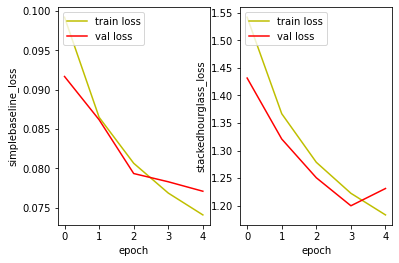

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot(121)
plt.plot(simple_history.history['loss'], 'y', label = 'train loss')
plt.plot(simple_history.history['val_loss'], 'r', label = 'val loss')
plt.xlabel('epoch')
plt.ylabel('simplebaseline_loss')
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(train_loss, 'y', label = 'train loss')
plt.plot(val_loss, 'r', label = 'val loss')
plt.xlabel('epoch')
plt.ylabel('stackedhourglass_loss')
plt.legend(loc='upper left')

plt.show()

## 예측 엔진 만들기 (inference)

In [23]:
weight_path = os.getenv('HOME') + '/aiffel/aiffel_6/GD08/weights'

WEIGHTS_PATH = os.path.join(weight_path, stacked_model)

shg_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
shg_model.load_weights(WEIGHTS_PATH)


In [12]:
weight_path = os.getenv('HOME') + '/aiffel/aiffel_6/GD08/weights'

WEIGHTS_PATH = os.path.join(weight_path, 'simple_model-epoch-04-loss-0.0783.h5' )

simplebaseline_model = Simplebaseline(IMAGE_SHAPE)
simplebaseline_model.load_weights(WEIGHTS_PATH)

In [13]:
# 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정. 
# 변수에 저장되는 것은 해당 부위를 나타내는 인덱스.

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]


In [14]:
# heatmap에서 최대값을 찾는 함수

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


In [15]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


In [16]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp


In [17]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()


### stacked hour glass infer

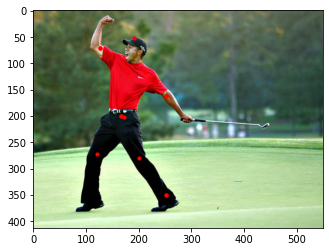

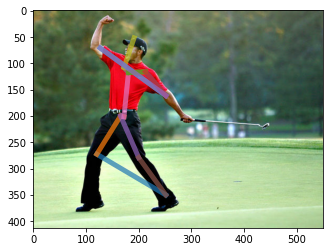

In [24]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(shg_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### simplebaseline infer

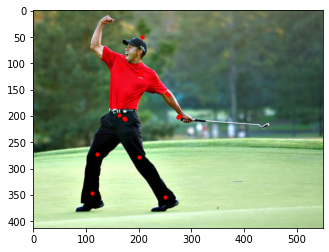

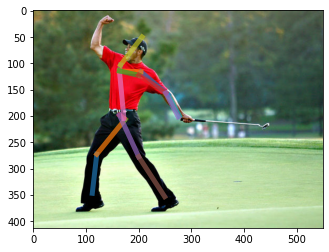

In [18]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(simplebaseline_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## 회고하기

1. simplebaseline model을 학습할 때, 기존에 정의한 trainer, train을 사용하여 학습하면 문제가 생긴다.  
   이 부분을 해결하기 위해 simplebaseline과 stackedhourglass 모델 두 경우에 대해 다른 compute_loss를 계산했다.
   하지만, simplebaseline 모델을 정의할 때, resnet 모델을 앞 단에서 먼저 함수 밖에서 선언했는데, 이게 문제라고 한다.  
   실제로 해보고 돌아가는 지는 시간관계상 못해보았지만, 코드는 다 수정해놓았다.
   
2. 같은 loss를 사용했는데 크게 차이가 나는 이유는 batch_size 차이에서 오는 건가? 라는 의문이 들었다.  
   loss가 적고 크게 나오는데에 batch_size가 미치는 영향에 대해 생각해 볼 필요가 있다.

3. loss가 크게 다름에도 불구하고 실제로 inference를 해보면 비슷한 성능을 내는 것을 확인할 수 있었다.

4. 모델의 크기에 큰 차이가 있음에도 실제 결과의 큰 차이가 없는 것이 흥미로웠다.
   
